# Projet EnergiSight - Phase 1 : EDA Deep-Dive
**Startup :** GreenSight Lomé  


Ce notebook contient l'Analyse Exploratoire des Données (EDA) pour le dataset de Seattle 2016. L'objectif est de préparer les données pour prédire la consommation d'énergie et les émissions de CO2 des bâtiments non-résidentiels.

In [1]:
from folium.plugins.heat_map import HeatMap
#importation des bibliotheques
import numpy as np
import pandas as pd
import math
import datetime as datetime
import warnings

#statistique bibliotheque
from scipy import stats
from scipy.stats import shapiro, skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor

#visulalisation bibliotheque
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import missingno as msno

#visualisation interactive bibliotheque
import folium
from folium.plugins import HeatMap
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as make_subplots
import geopandas as gpd

## Paramétrage de l'affichage
Pour assurer la cohérence visuelle et la lisibilité des analyses du projet EnergiSight, nous définissons des standards de présentation

In [2]:
sns.set_theme(style='whitegrid',palette='viridis')
plt.rcParams['figure.figsize']=(12,8)
plt.rcParams['font.size']=12

#configuration pour pandas
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
# Constantes pour le projet GreenSight
TARGET_CO2 = 'totalghgemissions'
TARGET_ENERGY = 'siteenergyusekbtu'
SEED = 42 # Pour la reproductibilité des analyses futures

---
###  Chargement du dataset

chargement du dataset afin d'avoir un visuelle sur cela et commencer le travail

In [4]:
df_raw=pd.read_csv('/content/drive/MyDrive/D-CLIC/projet_energisight/data/2016_Building_Energy_Benchmarking.csv')
# normalisation des ccolonnes
df_raw.columns = [c.lower().replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '') for c in df_raw.columns]
print(f"Dataset chargé : {df_raw.shape[0]} lignes × {df_raw.shape[1]} colonnes")

Dataset chargé : 3376 lignes × 46 colonnes


---
### Inspection des types & premières valeurs

`df.info()` donne d'un coup : le type de chaque colonne, le nombre de valeurs non-nulles, et la mémoire utilisée.

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   osebuildingid                    3376 non-null   int64  
 1   datayear                         3376 non-null   int64  
 2   buildingtype                     3376 non-null   object 
 3   primarypropertytype              3376 non-null   object 
 4   propertyname                     3376 non-null   object 
 5   address                          3376 non-null   object 
 6   city                             3376 non-null   object 
 7   state                            3376 non-null   object 
 8   zipcode                          3360 non-null   float64
 9   taxparcelidentificationnumber    3376 non-null   object 
 10  councildistrictcode              3376 non-null   int64  
 11  neighborhood                     3376 non-null   object 
 12  latitude            

Première action : corriger immédiatement `ZipCode` qui est lu en `float64` par pandas.
C'est une variable **catégorielle** (code postal), pas un nombre — on ne peut pas faire de moyenne de codes postaux.

In [6]:
# ZipCode est catégoriel, pas numérique
df_raw['zipcode'] = df_raw['zipcode'].astype(str).str.replace('.0', '', regex=False)

In [7]:
# Vue d'ensemble statistique
df_raw.describe(include='all')

osebuildingid  datayear    buildingtype   primarypropertytype  \
count        3376.000  3376.000            3376                  3376   
unique            NaN       NaN               8                    24   
top               NaN       NaN  NonResidential  Low-Rise Multifamily   
freq              NaN       NaN            1460                   987   
mean        21208.991  2016.000             NaN                   NaN   
std         12223.757     0.000             NaN                   NaN   
min             1.000  2016.000             NaN                   NaN   
25%         19990.750  2016.000             NaN                   NaN   
50%         23112.000  2016.000             NaN                   NaN   
75%         25994.250  2016.000             NaN                   NaN   
max         50226.000  2016.000             NaN                   NaN   

           propertyname                      address     city state zipcode  \
count              3376                         3376     3376  3376    3376   
unique             3362                         3354        1     1      56   
top     Northgate Plaza  309 South Cloverdale Street  Seattle    WA   98109   
freq                  3                            4     3376  3376     294   
mean                NaN                          NaN      NaN   NaN     NaN   
std                 NaN                          NaN      NaN   NaN     NaN   
min                 NaN                          NaN      NaN   NaN     NaN   
25%                 NaN                          NaN      NaN   NaN     NaN   
50%                 NaN                          NaN      NaN   NaN     NaN   
75%                 NaN                          NaN      NaN   NaN     NaN   
max                 NaN                          NaN      NaN   NaN     NaN   

       taxparcelidentificationnumber  councildistrictcode neighborhood  \
count                           3376             3376.000         3376   
unique                          3268                  NaN           19   
top                       1625049001                  NaN     DOWNTOWN   
freq                               8                  NaN          573   
mean                             NaN                4.439          NaN   
std                              NaN                2.121          NaN   
min                              NaN                1.000          NaN   
25%                              NaN                3.000          NaN   
50%                              NaN                4.000          NaN   
75%                              NaN                7.000          NaN   
max                              NaN                7.000          NaN   

        latitude  longitude  yearbuilt  numberofbuildings  numberoffloors  \
count   3376.000   3376.000   3376.000           3368.000        3376.000   
unique       NaN        NaN        NaN                NaN             NaN   
top          NaN        NaN        NaN                NaN             NaN   
freq         NaN        NaN        NaN                NaN             NaN   
mean      47.624   -122.335   1968.573              1.107           4.709   
std        0.048      0.027     33.088              2.108           5.494   
min       47.499   -122.414   1900.000              0.000           0.000   
25%       47.600   -122.351   1948.000              1.000           2.000   
50%       47.619   -122.332   1975.000              1.000           4.000   
75%       47.657   -122.319   1997.000              1.000           5.000   
max       47.734   -122.221   2015.000            111.000          99.000   

        propertygfatotal  propertygfaparking  propertygfabuildings  \
count           3376.000            3376.000              3376.000   
unique               NaN                 NaN                   NaN   
top                  NaN                 NaN                   NaN   
freq                 NaN                 NaN                   NaN   
mean           948

In [8]:
# Premières lignes pour se familiariser avec les données
df_raw.head(5)

osebuildingid  datayear    buildingtype primarypropertytype  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  propertyname          address     city state zipcode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA   98101   
1              Paramount Hotel  724 Pine street  Seattle    WA   98101   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA   98101   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA   98101   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA   98121   

  taxparcelidentificationnumber  councildistrictcode neighborhood  latitude  \
0                    0659000030                    7     DOWNTOWN    47.612   
1                    0659000220                    7     DOWNTOWN    47.613   
2                    0659000475                    7     DOWNTOWN    47.614   
3                    0659000640                    7     DOWNTOWN    47.614   
4                    0659000970                    7     DOWNTOWN    47.614   

   longitude  yearbuilt  numberofbuildings  numberoffloors  propertygfatotal  \
0   -122.338       1927              1.000              12             88434   
1   -122.334       1996              1.000              11            103566   
2   -122.338       1969              1.000              41            956110   
3   -122.337       1926              1.000              10             61320   
4   -122.340       1980              1.000              18            175580   

   propertygfaparking  propertygfabuildings      listofallpropertyusetypes  \
0                   0                 88434                          Hotel   
1               15064                 88502     Hotel, Parking, Restaurant   
2              196718                759392                          Hotel   
3                   0                 61320                          Hotel   
4               62000                113580  Hotel, Parking, Swimming Pool   

  largestpropertyusetype  largestpropertyusetypegfa  \
0                  Hotel                  88434.000   
1                  Hotel                  83880.000   
2                  Hotel                 756493.000   
3                  Hotel                  61320.000   
4                  Hotel                 123445.000   

  secondlargestpropertyusetype  secondlargestpropertyusetypegfa  \
0                          NaN                              NaN   
1                      Parking                        15064.000   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                        68009.000   

  thirdlargestpropertyusetype  thirdlargestpropertyusetypegfa  \
0                         NaN                             NaN   
1                  Restaurant                        4622.000   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                           0.000   

  yearsenergystarcertified  energystarscore  siteeuikbtu_sf  siteeuiwnkbtu_sf  \
0                      NaN           60.000          81.700            84.300   
1                      NaN           61.000          94.800            97.900   
2                      NaN           43.000          96.000            97.700   
3                      NaN           56.000         110.800           113.300   
4                      NaN           75.000         114.800           118.700   

   sourceeuikbtu_sf  sourceeuiwnkbtu_sf  siteenergyusekbtu  \
0           182.500             189.000        7226362.500   


---
### Doublons

Chaque bâtiment a un identifiant unique `OSEBuildingID`.
On vérifie qu'il n'y a pas de bâtiment enregistré deux fois.

In [9]:
dupes = df_raw.duplicated(subset=['osebuildingid']).sum()
print(f'Doublons sur osebuildingid : {dupes}')

# Vérification aussi sur les identifiants textuels
print(f'Noms de propriétés uniques : {df_raw["propertyname"].nunique()} '
      f'(sur {len(df_raw)} lignes)')

# Afficher les doublons si ils existent
if dupes > 0:
    print('\nBâtiments dupliqués :')
    display(df_raw[df_raw.duplicated(subset=['osebuildingid'], keep=False)]
            [['osebuildingid', 'propertyname', 'address']])

Doublons sur osebuildingid : 0
Noms de propriétés uniques : 3362 (sur 3376 lignes)


---
### Analyse des valeurs manquantes

On quantifie les manquants **avant** toute décision de nettoyage.

In [10]:
miss = pd.DataFrame({
    'Manquants': df_raw.isnull().sum(),
    'Pct (%)':   (df_raw.isnull().sum() / len(df_raw) * 100).round(1)
}).sort_values('Pct (%)', ascending=False)

miss_nonzero = miss[miss['Manquants'] > 0]

print(f'Cellules manquantes au total : {df_raw.isnull().sum().sum():,}')
print(f'Colonnes avec >50% vides     : {(miss["Pct (%)"] > 50).sum()}')
print(f'Colonnes avec 1-50% vides    : {((miss["Pct (%)"] > 0) & (miss["Pct (%)"] <= 50)).sum()}')
print()
display(miss_nonzero)

Cellules manquantes au total : 19,936
Colonnes avec >50% vides     : 7
Colonnes avec 1-50% vides    : 18



Manquants  Pct (%)
comments                              3376  100.000
outlier                               3344   99.100
yearsenergystarcertified              3257   96.500
thirdlargestpropertyusetype           2780   82.300
thirdlargestpropertyusetypegfa        2780   82.300
secondlargestpropertyusetype          1697   50.300
secondlargestpropertyusetypegfa       1697   50.300
energystarscore                        843   25.000
largestpropertyusetypegfa               20    0.600
largestpropertyusetype                  20    0.600
electricitykwh                           9    0.300
listofallpropertyusetypes                9    0.300
sourceeuikbtu_sf                         9    0.300
sourceeuiwnkbtu_sf                       9    0.300
ghgemissionsintensity                    9    0.300
totalghgemissions                        9    0.300
naturalgastherms                         9    0.300
steamusekbtu                             9    0.300
naturalgaskbtu                           9    0.300
electricitykbtu                          9    0.300
siteenergyusewnkbtu                      6    0.200
siteeuikbtu_sf                           7    0.200
numberofbuildings                        8    0.200
siteeuiwnkbtu_sf                         6    0.200
siteenergyusekbtu                        5    0.100

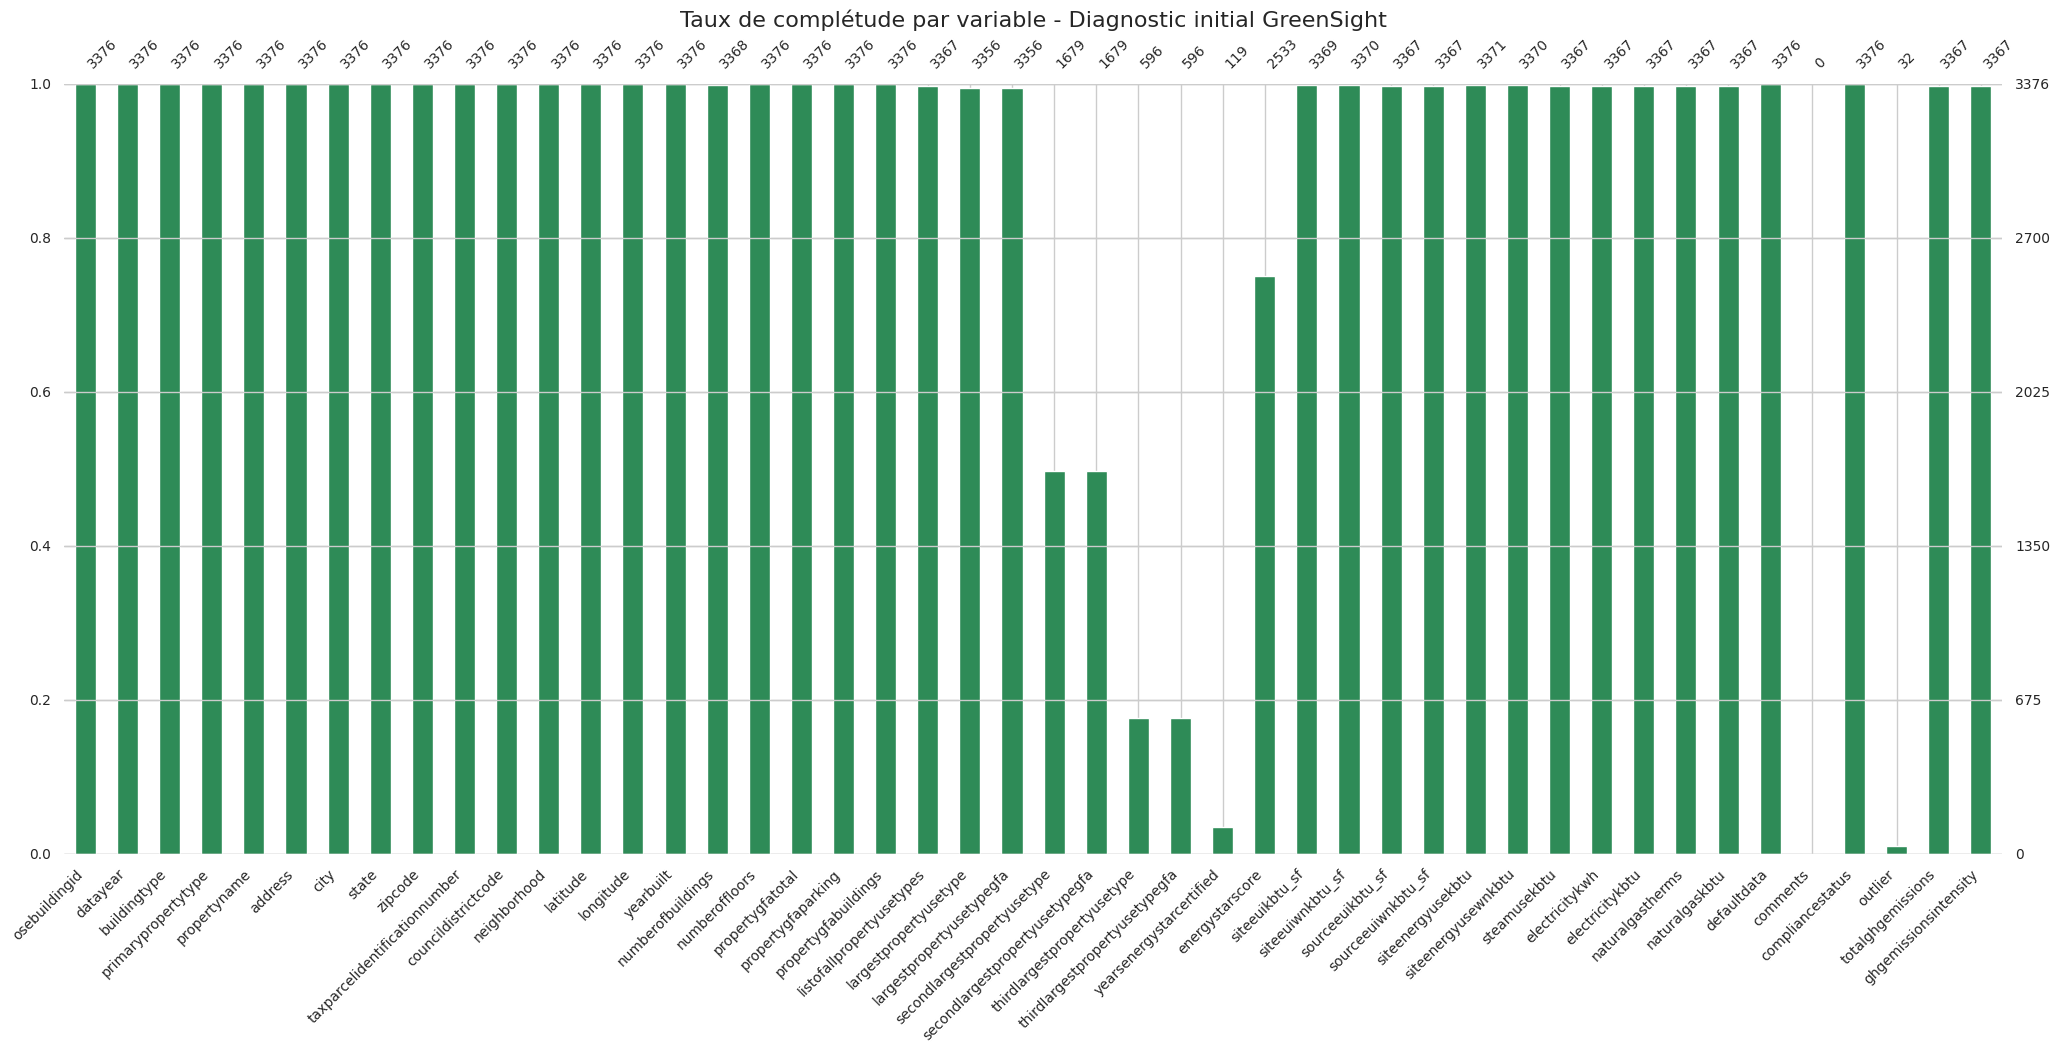

In [11]:
# Analyse visuelle des valeurs manquantes
plt.figure(figsize=(15, 6))
msno.bar(df_raw, color="seagreen", fontsize=10)
plt.title("Taux de complétude par variable - Diagnostic initial GreenSight", fontsize=16)
plt.show()

---
### Répartition des types de bâtiments

Le projet cible uniquement les **bâtiments non-résidentiels**.
On identifie combien de lignes sont hors scope.

In [12]:
print('Répartition buildingtype :')
print(df_raw['buildingtype'].value_counts())
print()

# Résidentiels à exclure
residential = ['Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'Multifamily HR (10+)']
n_residentiel = df_raw['buildingtype'].isin(residential).sum()
n_non_residentiel = len(df_raw) - n_residentiel

print(f'Résidentiels (hors scope)   : {n_residentiel} lignes ({n_residentiel/len(df_raw)*100:.1f}%)')
print(f'Non-résidentiels (in scope) : {n_non_residentiel} lignes ({n_non_residentiel/len(df_raw)*100:.1f}%)')

Répartition buildingtype :
buildingtype
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

Résidentiels (hors scope)   : 1708 lignes (50.6%)
Non-résidentiels (in scope) : 1668 lignes (49.4%)


---
### Colonne `Outlier` native du dataset

Seattle a déjà pré-labellisé des bâtiments comme aberrants.
On l'analyse avant de la supprimer — c'est une information utile.

In [13]:
print('Contenu de la colonne outlier :')
print(df_raw['outlier'].value_counts(dropna=False))
print()

# Qui sont ces bâtiments ?
outliers_seattle = df_raw[df_raw['outlier'].notna()]
if len(outliers_seattle) > 0:
    display(outliers_seattle[
        ['osebuildingid', 'propertyname', 'buildingtype',
         'propertygfatotal', TARGET_ENERGY, TARGET_CO2, 'outlier']
    ].sort_values('outlier'))

Contenu de la colonne outlier :
outlier
NaN             3344
Low outlier       23
High outlier       9
Name: count, dtype: int64



osebuildingid                    propertyname          buildingtype  \
226             350      Second And Spring Building        NonResidential   
1707          23174         Taylor Anne Condominium  Multifamily LR (1-4)   
3265          49943                   Stewart House  Multifamily LR (1-4)   
2863          27245            St. Johns Apartments  Multifamily LR (1-4)   
2922          27526                        Vali Hai  Multifamily LR (1-4)   
2763          26852                  Atlas Building  Multifamily LR (1-4)   
517             704            401 Elliott Ave West        NonResidential   
3092          29390    Commodore Duchess Apartments  Multifamily MR (5-9)   
3082          28735                      Building 4  Multifamily LR (1-4)   
2801          27007        Seattle Community Church        NonResidential   
2476          25756       West Olympic Condominiums  Multifamily LR (1-4)   
2450          25674          (ID25674) COMET TAVERN        NonResidential   
2410          25553  J & M HOTEL BUILDING (ID25553)        NonResidential   
2353          25358           One West Condominiums  Multifamily LR (1-4)   
3152          43948           Georgetown Steamplant    Nonresidential COS   
2216          24825                   2233 Building        NonResidential   
2189          24717        1701 First Ave South LLC        NonResidential   
1945          23912                  1416 S Jackson        NonResidential   
1888          23708           Anne Vista Apartments  Multifamily LR (1-4)   
1611          22830                  Freedom Church        NonResidential   
1341          21562           Diplomat Condominiums  Multifamily LR (1-4)   
1295          21474                  The Lusty Lady        NonResidential   
1229          21315                 1518 Fifith Ave        NonResidential   
1045          20617           Seattle Habitat Store        NonResidential   
962           20367           City Lights on Harbor  Multifamily LR (1-4)   
839           19967                  Queen Anne Gym     SPS-District K-12   
834           19934                   Belmont Lofts  Multifamily LR (1-4)   
720           19708                       Bay Vista  Multifamily HR (10+)   
448             608          411 1ST AVE  S (ID608)        NonResidential   
384             539               University Center        NonResidential   
2129          24547       Islamic School of Seattle        NonResidential   
3341          50071       The Westside Off Broadway  Multifamily MR (5-9)   

      propertygfatotal  siteenergyusekbtu  totalghgemissions       outlier  
226             172842       41399504.000            362.660  High outlier  
1707             30569        6834431.000             54.250  High outlier  
3265             49000        4602793.500             78.390  High outlier  
2863             24682        2681771.000             96.180  High outlier  
2922             43346        4519115.000            148.020  High outlier  
2763             46560        6881405.500            284.420  High outlier  
517             129551       27137190.000            189.180  High outlier  
3092             97923       10343027.000            686.530  High outlier  
3082             46725       13459221.000            531.960  High outlier  
2801             20039         104722.297              0.730   Low outlier  
2476             22000         154798.094              1.080   Low outlier  
2450             32100         108200.398              5.220   Low outlier  
2410             25450         503744.688              3.510   Low outlier  
2353             26261         200056.594              1.390   Low outlier  
3152             39212          72370.398              0.500   Low outlier  
2216             20970         204499.094              5.430   Low outlier  
2189             27690          16808.900              0.120   Low outlier  
1945             45068         284857.312              8.590   Low outlier  
1

---
### Vérification des contraintes physiques

Certaines erreurs ne sont pas des valeurs manquantes mais des **incohérences** :
- Une surface totale inférieure à la surface bâtie : impossible
- Une consommation nulle ou négative : physiquement impossible pour un bâtiment actif
- Des émissions nulles ou négatives

In [14]:
print('CONTRAINTES PHYSIQUES')
print('─' * 45)

# Surface totale < surface bâtie ?
mask_surf = df_raw['propertygfatotal'] < df_raw['propertygfabuildings']
print(f'GFATotal < GFABuildings          : {mask_surf.sum()} cas')

# Consommations impossibles
print(f'{TARGET_ENERGY} ≤ 0      : {(df_raw[TARGET_ENERGY] <= 0).sum()} cas')
print(f'{TARGET_CO2} ≤ 0  : {(df_raw[TARGET_CO2] <= 0).sum()} cas')

# Années de construction aberrantes
print(f'YearBuilt > 2016                 : {(df_raw["yearbuilt"] > 2016).sum()} cas')
print(f'YearBuilt < 1850                 : {(df_raw["yearbuilt"] < 1850).sum()} cas')

# NumberofFloors = 0 ?
print(f'NumberofFloors = 0               : {(df_raw["numberoffloors"] == 0).sum()} cas')

CONTRAINTES PHYSIQUES
─────────────────────────────────────────────
GFATotal < GFABuildings          : 0 cas
siteenergyusekbtu ≤ 0      : 18 cas
totalghgemissions ≤ 0  : 10 cas
YearBuilt > 2016                 : 0 cas
YearBuilt < 1850                 : 0 cas
NumberofFloors = 0               : 16 cas


---
### 1.9 Skewness des variables numériques

Le skewness mesure l'asymétrie d'une distribution :
- Skew **proche de 0** : distribution symétrique (normale)
- Skew **> 2** : asymétrie modérée : winsorisation suffisante
- Skew **> 5** : forte asymétrie : transformation `log1p` nécessaire avant winsorisation

Cette analyse déterminera quelle stratégie on applique à chaque variable dans l'étape 2.

In [15]:
num_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
# Exclure identifiants et années
num_cols = [c for c in num_cols
            if c not in ['OSEBuildingID', 'DataYear', 'CouncilDistrictCode']]

skew_df = pd.DataFrame({
    'Colonne' : num_cols,
    'Skewness': [df_raw[c].dropna().skew() for c in num_cols],
    'Manquants': [df_raw[c].isna().sum() for c in num_cols],
}).sort_values('Skewness', ascending=False).reset_index(drop=True)

# Catégorisation
def skew_label(s):
    if abs(s) > 5:  return '🔴 log1p nécessaire'
    elif abs(s) > 2: return '🟡 winsor suffisant'
    else:            return '🟢 OK'

skew_df['Stratégie'] = skew_df['Skewness'].apply(skew_label)
display(skew_df)

Colonne  Skewness  Manquants           Stratégie
0                 numberofbuildings    43.395          8  🔴 log1p nécessaire
1         largestpropertyusetypegfa    30.096         20  🔴 log1p nécessaire
2                  naturalgastherms    30.039          9  🔴 log1p nécessaire
3                    naturalgaskbtu    30.039          9  🔴 log1p nécessaire
4                   electricitykbtu    28.728          9  🔴 log1p nécessaire
5                    electricitykwh    28.728          9  🔴 log1p nécessaire
6              propertygfabuildings    27.624          0  🔴 log1p nécessaire
7                      steamusekbtu    26.721          9  🔴 log1p nécessaire
8                 siteenergyusekbtu    24.842          5  🔴 log1p nécessaire
9                  propertygfatotal    24.129          0  🔴 log1p nécessaire
10                totalghgemissions    19.482          9  🔴 log1p nécessaire
11              siteenergyusewnkbtu    15.269          6  🔴 log1p nécessaire
12   thirdlargestpropertyusetypegfa     9.197       2780  🔴 log1p nécessaire
13               propertygfaparking     6.651          0  🔴 log1p nécessaire
14                 sourceeuikbtu_sf     6.595          9  🔴 log1p nécessaire
15               sourceeuiwnkbtu_sf     6.570          9  🔴 log1p nécessaire
16                   numberoffloors     5.922          0  🔴 log1p nécessaire
17            ghgemissionsintensity     5.593          9  🔴 log1p nécessaire
18  secondlargestpropertyusetypegfa     5.033       1697  🔴 log1p nécessaire
19                   siteeuikbtu_sf     4.982          7  🟡 winsor suffisant
20                 siteeuiwnkbtu_sf     4.828          6  🟡 winsor suffisant
21                         latitude     0.140          0                🟢 OK
22                         datayear     0.000          0                🟢 OK
23                    osebuildingid    -0.008          0                🟢 OK
24              councildistrictcode    -0.070          0                🟢 OK
25                        longitude    -0.138          0                🟢 OK
26                        yearbuilt    -0.539          0                🟢 OK
27                  energystarscore    -0.859        843                🟢 OK
28                         comments       NaN       3376                🟢 OK

# etape 2

**Ce qu'on sait de l'étape 1 :**

| Observation | Décision |
|---|---|
| 1708 bâtiments résidentiels | Supprimés (hors scope) |
| 18 lignes `SiteEnergyUse ≤ 0` | Supprimées (physiquement impossible) |
| 10 lignes `TotalGHGEmissions ≤ 0` | Supprimées (physiquement impossible) |
| 16 lignes `NumberofFloors = 0` | Conservés tels quels — valeur légitime ou champ vide non renseigné |
| 19 variables avec skew > 5 | Stratégie `log1p` + winsor P1/P99 |
| 2 variables avec 2 < skew ≤ 5 | Winsor P1/P99 simple |
| Targets avec NaN | Drop NaN uniquement — **pas de suppression d'outliers** |

In [16]:
#variables
WINSOR_LOW    = 0.01
WINSOR_HIGH   = 0.99

### Définition des variables par stratégie

In [17]:
LOG_WINSOR_FEATURES = [
    'numberofbuildings',
    'largestpropertyusetypegfa',
    'naturalgastherms',
    'naturalgaskbtu',
    'electricitykbtu',
    'electricitykwh',
    'propertygfabuildings',
    'steamusekbtu',
    'propertygfatotal',
    'siteenergyusewnkbtu',
    'thirdlargestpropertyusetypegfa',
    'propertygfaparking',
    'sourceeuikbtu_sf',
    'sourceeuiwnkbtu_sf',
    'numberoffloors',
    'ghgemissionsintensity',
    'secondlargestpropertyusetypegfa',
]

WINSOR_ONLY_FEATURES = [
    'siteeuikbtu_sf',
    'siteeuiwnkbtu_sf',
]

TARGET_CO2    = 'totalghgemissions'
TARGET_ENERGY = 'siteenergyusekbtu'

### 2.2 Utilitaires

In [18]:
def plot_before_after(col_name, before, after, title, color='#2a9d8f'):
    """3 graphiques : distribution avant | boxplot avant | boxplot après."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle(title, fontsize=11, fontweight='bold', y=1.02)

    sns.histplot(before, kde=True, ax=axes[0], color='steelblue', bins=40)
    axes[0].axvline(before.median(), color='tomato', linestyle='--',
                    lw=1.5, label=f'médiane={before.median():.2f}')
    axes[0].set_title(f'Distribution avant  (skew={before.skew():.1f})')
    axes[0].legend(fontsize=8)
    axes[0].set_xlabel(col_name)

    sns.boxplot(x=before, ax=axes[1], color='#f4a261')
    axes[1].set_title('Boxplot avant')

    sns.boxplot(x=after, ax=axes[2], color=color)
    axes[2].set_title(f'Boxplot après  (skew={after.skew():.2f})')

    plt.tight_layout()
    plt.show()


print('Utilitaires chargés')

Utilitaires chargés


---
###  Nettoyage physique

In [19]:
print('━━━ ÉTAPE 2.1 : Nettoyage physique ━━━')
print()
n0 = len(df_raw)
df = df_raw.copy()

# ── 1. Scope : bâtiments non-résidentiels uniquement ─────────────────────────
residential = ['Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'Multifamily HR (10+)']
df = df[~df['buildingtype'].isin(residential)].copy()
print(f'Résidentiels supprimés             : {n0 - len(df):>4} lignes')

# ── 2. Consommation nulle ou négative ─────────────────────────────────────────
n1 = len(df)
df = df[df[TARGET_ENERGY] > 0]
print(f'SiteEnergyUse ≤ 0 supprimée        : {n1 - len(df):>4} lignes')

# ── 3. Émissions nulles ou négatives ──────────────────────────────────────────
n2 = len(df)
df = df[df[TARGET_CO2] > 0]
print(f'TotalGHGEmissions ≤ 0 supprimée    : {n2 - len(df):>4} lignes')

# ── 4. NumberofFloors = 0 → conservé tel quel ────────────────────────────────
# Vérification : les 16 bâtiments avec 0 étage incluent le Grand Hyatt Seattle,
# l'Université de Washington (9.3M sq ft), des campus, résidences universitaires.
# Très probablement des champs non renseignés, mais aussi possiblement des
# bâtiments de plain-pied légitimes (entrepôts, warehouses).
# Décision : on conserve 0 tel quel — aucune imputation.
# Le modèle apprendra à gérer ce cas via ses propres mécanismes.
n_floors_zero = (df['numberoffloors'] == 0).sum()
print(f'NumberofFloors=0 conservés         : {n_floors_zero:>4} lignes (aucune imputation)')

# ── 5. Exploitation de la colonne Outlier native avant suppression ─────────────
df['flag_seattle_outlier'] = df['outlier'].notna().astype(int)
n_flagged = df['flag_seattle_outlier'].sum()
print(f'Flag outlier Seattle créé          : {n_flagged:>4} bâtiments flagués')

df = df.reset_index(drop=True)
print()
print(f'✓ Dataset après nettoyage physique : {len(df)} lignes  '
      f'(supprimées : {n0 - len(df)})')

━━━ ÉTAPE 2.1 : Nettoyage physique ━━━

Résidentiels supprimés             : 1708 lignes
SiteEnergyUse ≤ 0 supprimée        :   18 lignes
TotalGHGEmissions ≤ 0 supprimée    :    2 lignes
NumberofFloors=0 conservés         :   16 lignes (aucune imputation)
Flag outlier Seattle créé          :   17 bâtiments flagués

✓ Dataset après nettoyage physique : 1648 lignes  (supprimées : 1728)


---
###  — Traitement des targets

**On drop uniquement les NaN.** Les outliers statistiques sont conservés — ils seront
gérés par la transformation `log1p(y)` au moment de la modélisation.

Pour illustrer pourquoi on garde les outliers, on affiche les distributions
avant et après `log1p` — c'est ce que verra le modèle.


  [totalghgemissions]
    NaN supprimés  : 0
    Lignes restantes : 1648
    Skew brut      : 14.14  →  skew log1p : 0.19


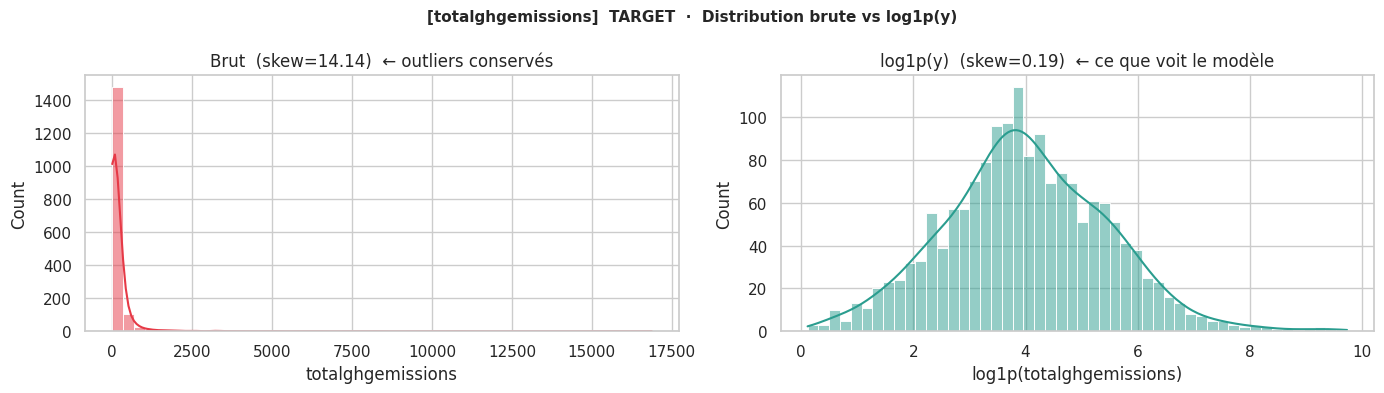


  [siteenergyusekbtu]
    NaN supprimés  : 0
    Lignes restantes : 1648
    Skew brut      : 17.96  →  skew log1p : 0.28


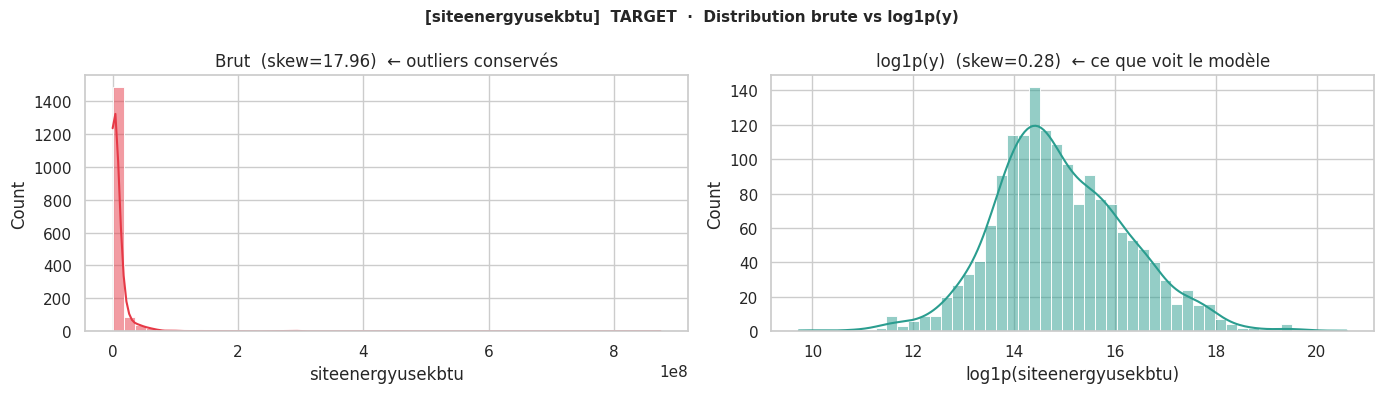


RAPPORT TARGETS :


Target  NaN supprimés  Lignes restantes  Skew brut  \
0  totalghgemissions              0              1648     14.140   
1  siteenergyusekbtu              0              1648     17.960   

   Skew log1p(y)  
0          0.190  
1          0.280


log1p(y) sera appliqué dans le notebook de modélisation :
  y_co2    = np.log1p(df["totalghgemissions"])
  y_energy = np.log1p(df["siteenergyusekbtu"])
  y_pred_reel = np.expm1(model.predict(X_test))


In [20]:
target_report = []

for col in [TARGET_CO2, TARGET_ENERGY]:
    n_nan = df[col].isna().sum()
    df    = df.dropna(subset=[col]).reset_index(drop=True)

    data     = df[col]
    data_log = np.log1p(data)

    print(f'\n  [{col}]')
    print(f'    NaN supprimés  : {n_nan}')
    print(f'    Lignes restantes : {len(df)}')
    print(f'    Skew brut      : {data.skew():.2f}  →  skew log1p : {data_log.skew():.2f}')

    # Graphique : brut vs log1p — ce que verra le modèle
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle(f'[{col}]  TARGET  ·  Distribution brute vs log1p(y)',
                 fontsize=11, fontweight='bold')

    sns.histplot(data,     kde=True, ax=axes[0], color='#e63946', bins=50)
    axes[0].set_title(f'Brut  (skew={data.skew():.2f})  ← outliers conservés')
    axes[0].set_xlabel(col)

    sns.histplot(data_log, kde=True, ax=axes[1], color='#2a9d8f', bins=50)
    axes[1].set_title(f'log1p(y)  (skew={data_log.skew():.2f})  ← ce que voit le modèle')
    axes[1].set_xlabel(f'log1p({col})')

    plt.tight_layout()
    plt.show()

    target_report.append({
        'Target'            : col,
        'NaN supprimés'     : n_nan,
        'Lignes restantes'  : len(df),
        'Skew brut'         : round(data.skew(), 2),
        'Skew log1p(y)'     : round(data_log.skew(), 2),
    })

print()
print('RAPPORT TARGETS :')
display(pd.DataFrame(target_report))
print()
print('log1p(y) sera appliqué dans le notebook de modélisation :')
print(f'  y_co2    = np.log1p(df["{TARGET_CO2}"])')
print(f'  y_energy = np.log1p(df["{TARGET_ENERGY}"])')
print('  y_pred_reel = np.expm1(model.predict(X_test))')

---
### — LOG_WINSOR features

**Séquence :** `log1p(x)` → winsorisation P1/P99 sur la version log

Une colonne `_log` est créée pour chaque variable. La colonne originale est **conservée**
pour l'interprétabilité. C'est la colonne `_log` qui sera envoyée au modèle.

  [numberofbuildings]  skew 32.3 - 1.61  |  winsor log [0.000 - 1.792]  |  col : numberofbuildings_log


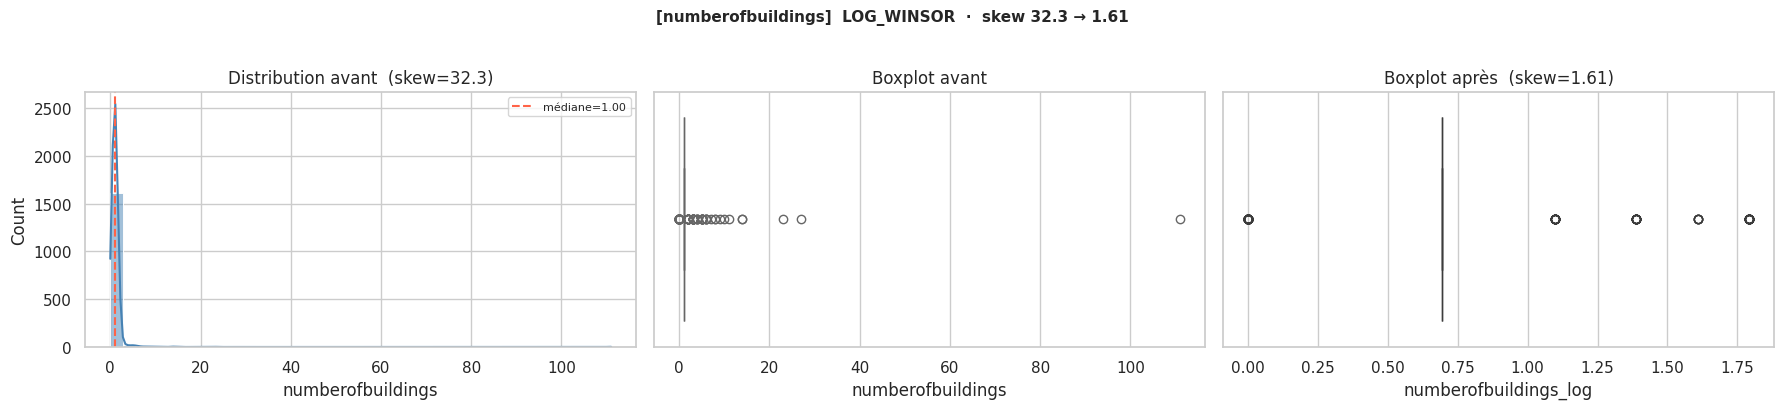

  [largestpropertyusetypegfa]  skew 23.4 - 0.79  |  winsor log [9.128 - 13.709]  |  col : largestpropertyusetypegfa_log


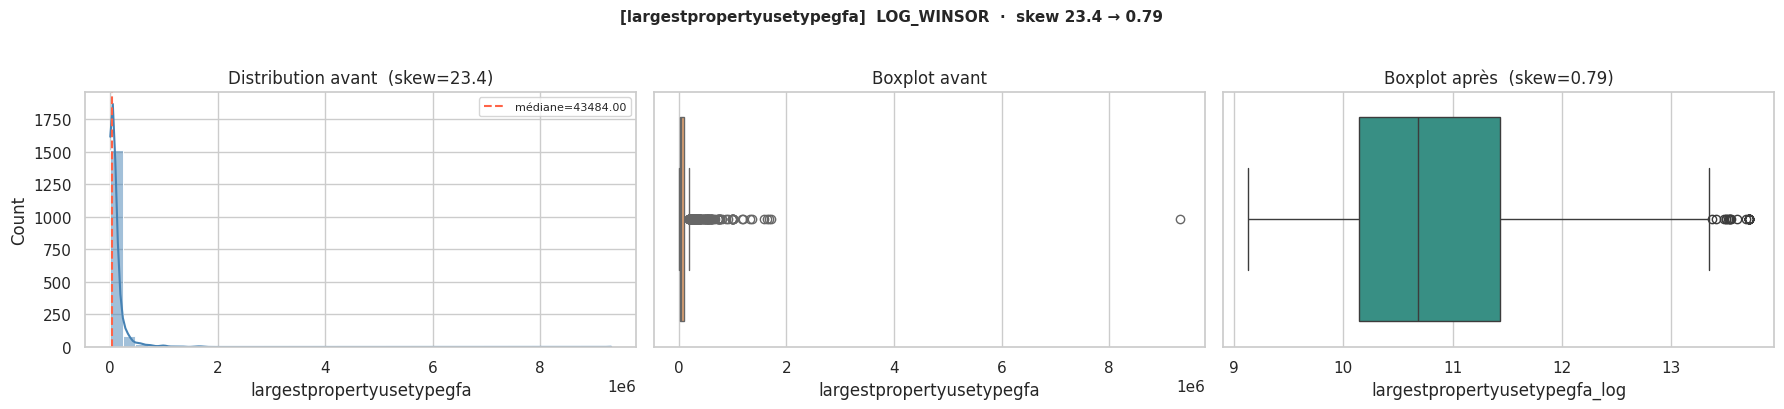

  [naturalgastherms]  skew 22.0 - -0.71  |  winsor log [0.000 - 12.211]  |  col : naturalgastherms_log


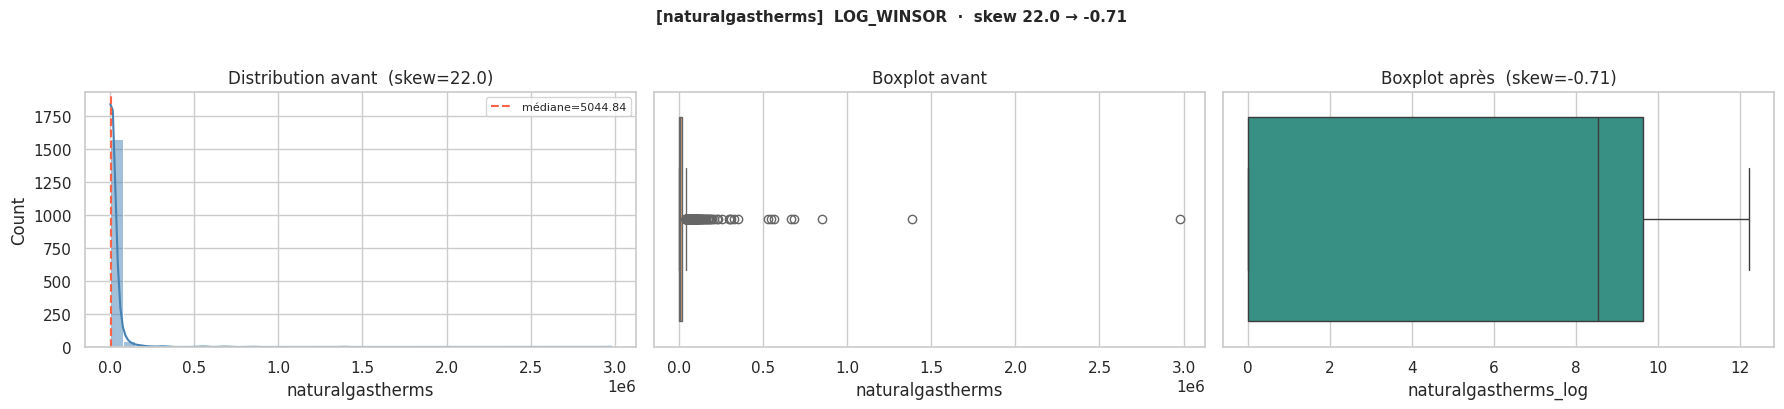

  [naturalgaskbtu]  skew 22.0 - -0.84  |  winsor log [0.000 - 16.816]  |  col : naturalgaskbtu_log


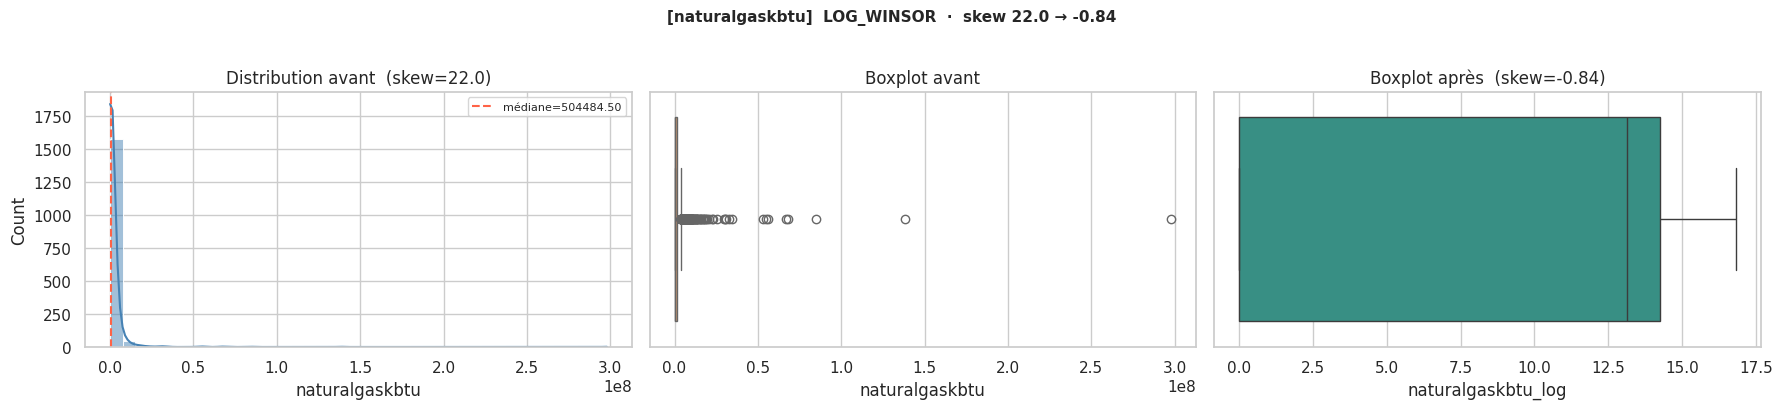

  [electricitykbtu]  skew 20.8 - 0.24  |  winsor log [11.334 - 17.859]  |  col : electricitykbtu_log


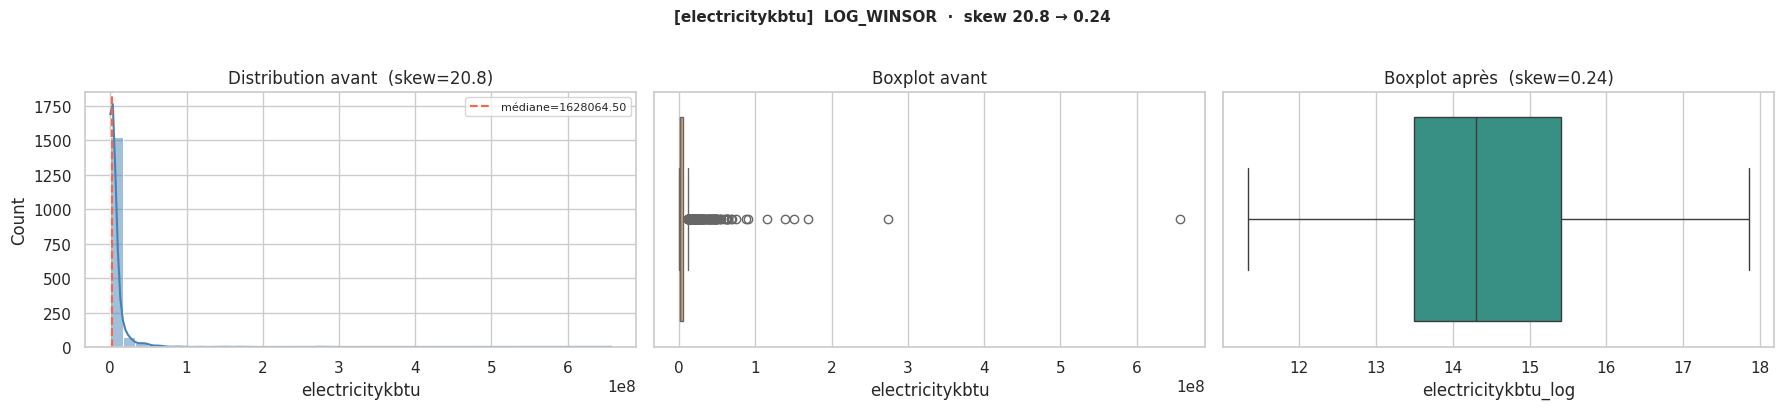

  [electricitykwh]  skew 20.8 - 0.24  |  winsor log [10.107 - 16.632]  |  col : electricitykwh_log


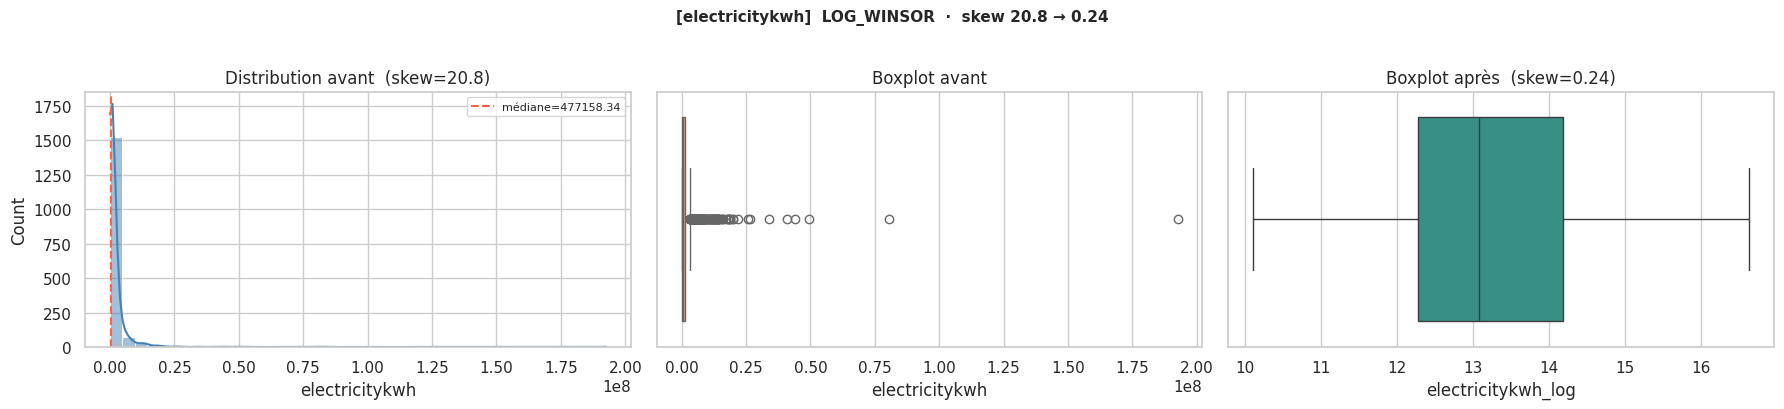

  [propertygfabuildings]  skew 21.9 - 1.05  |  winsor log [9.713 - 13.770]  |  col : propertygfabuildings_log


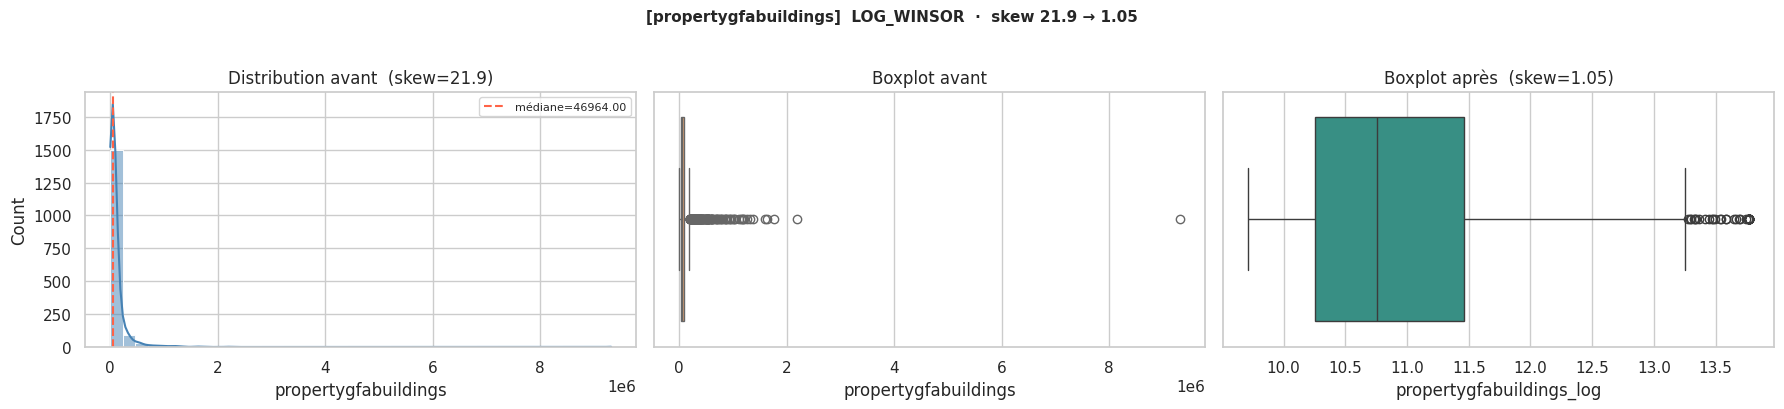

  [steamusekbtu]  skew 19.0 - 3.44  |  winsor log [0.000 - 16.036]  |  col : steamusekbtu_log


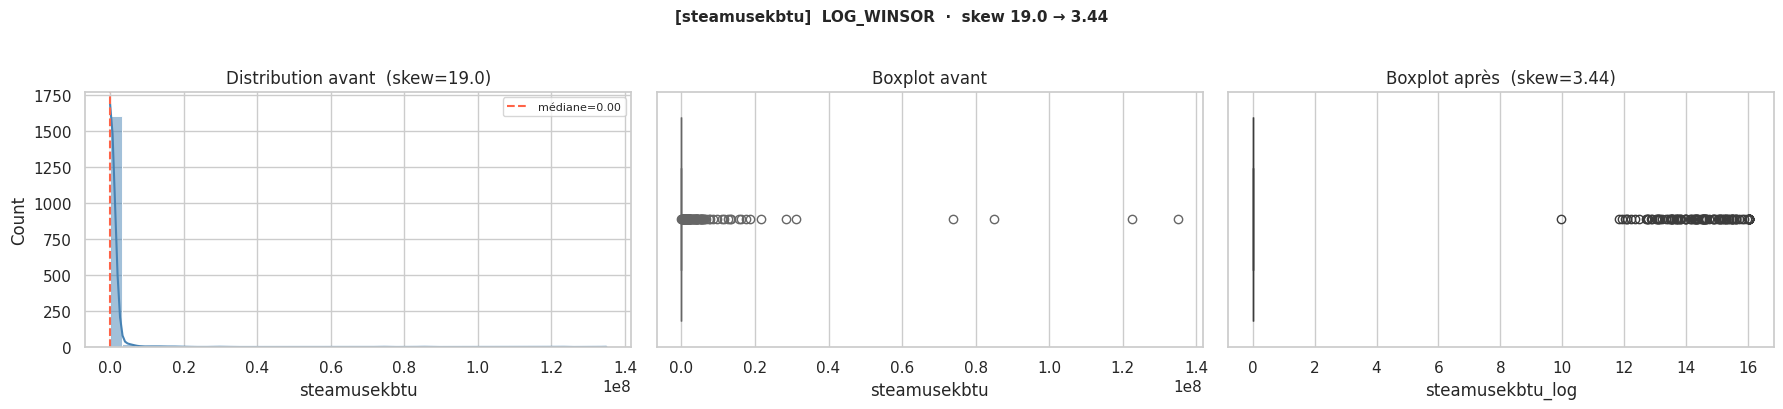

  [propertygfatotal]  skew 19.3 - 0.99  |  winsor log [9.905 - 13.911]  |  col : propertygfatotal_log


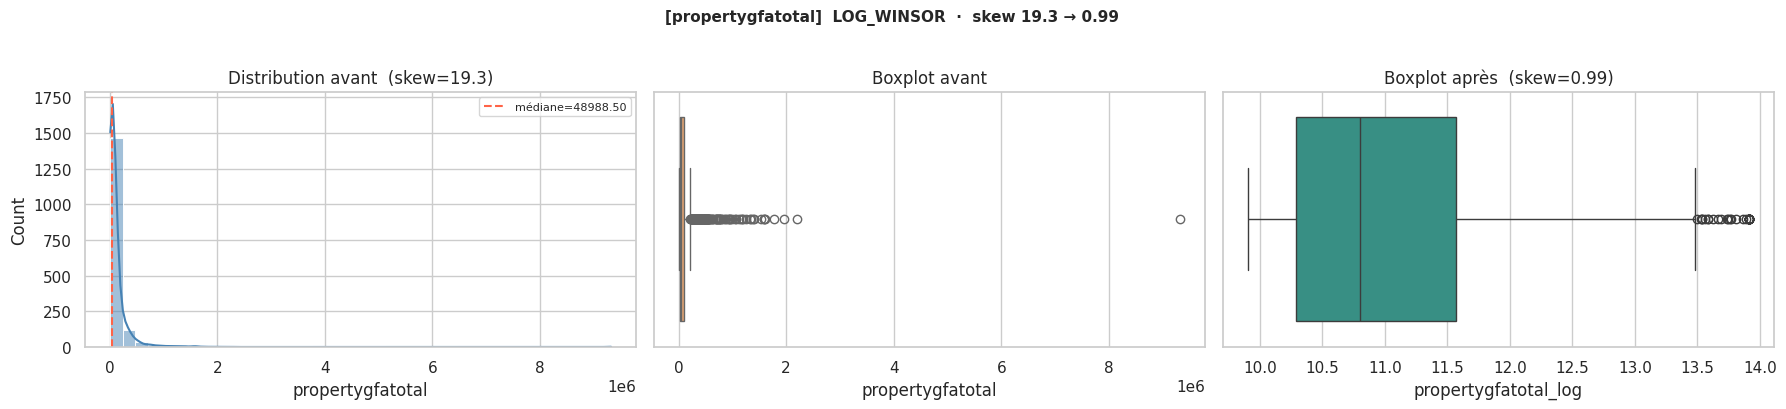

  [siteenergyusewnkbtu]  skew 11.3 - 0.11  |  winsor log [11.511 - 18.104]  |  col : siteenergyusewnkbtu_log


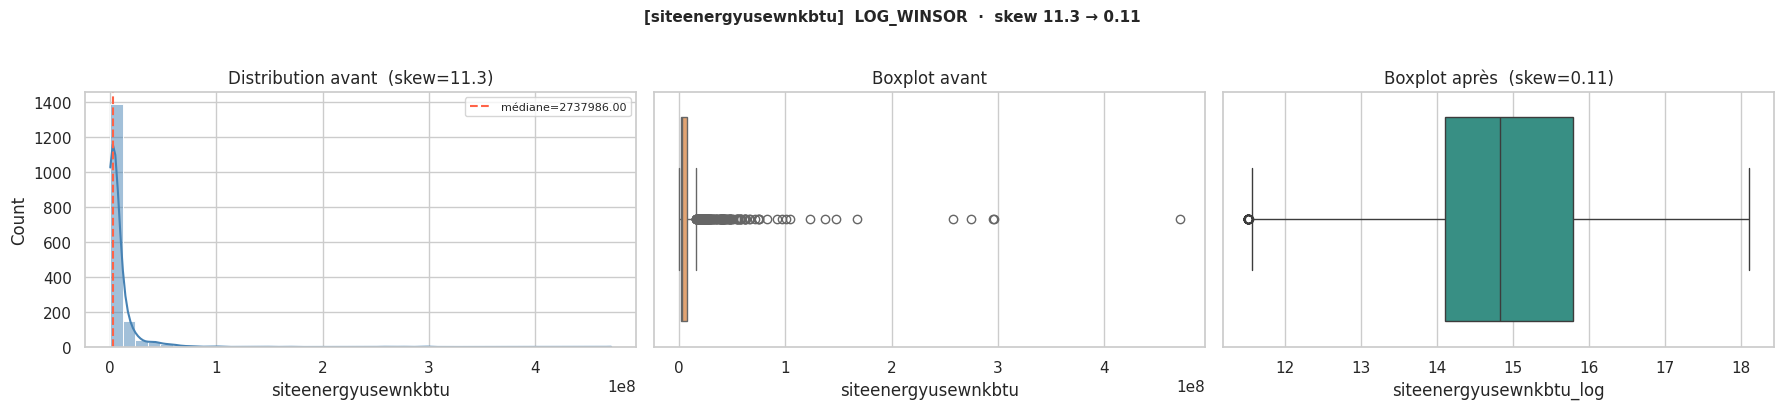

  [thirdlargestpropertyusetypegfa]  skew 7.6 - -2.19  |  winsor log [0.000 - 11.970]  |  col : thirdlargestpropertyusetypegfa_log


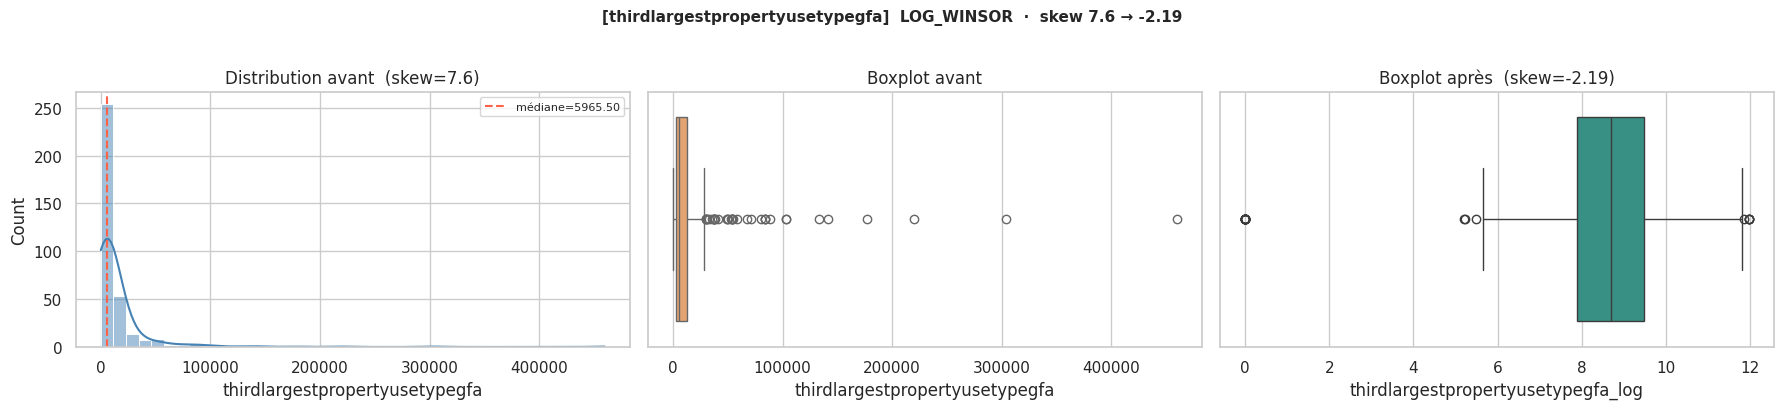

  [propertygfaparking]  skew 5.2 - 1.54  |  winsor log [0.000 - 12.214]  |  col : propertygfaparking_log


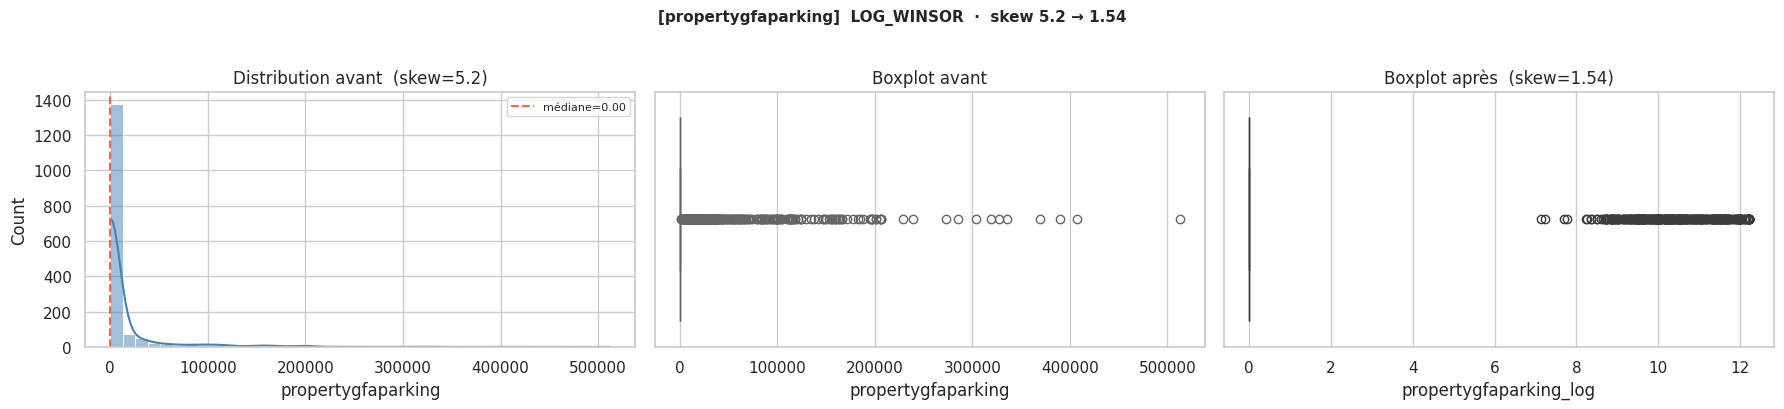

  [sourceeuikbtu_sf]  skew 5.0 - -0.26  |  winsor log [2.531 - 6.662]  |  col : sourceeuikbtu_sf_log


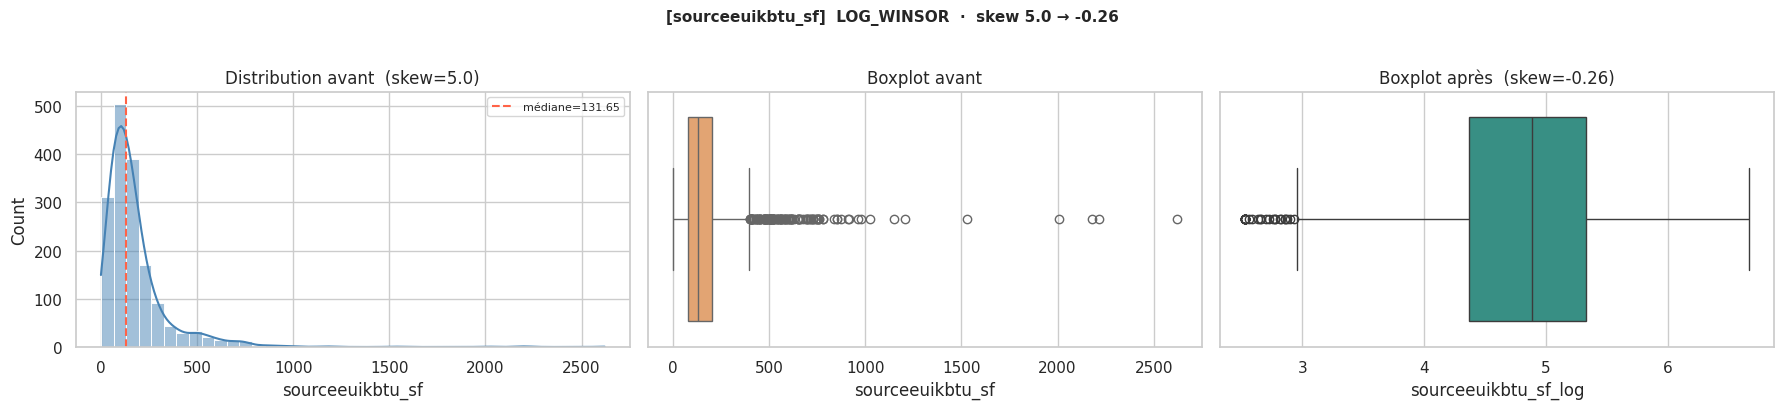

  [sourceeuiwnkbtu_sf]  skew 4.9 - -0.57  |  winsor log [1.957 - 6.673]  |  col : sourceeuiwnkbtu_sf_log


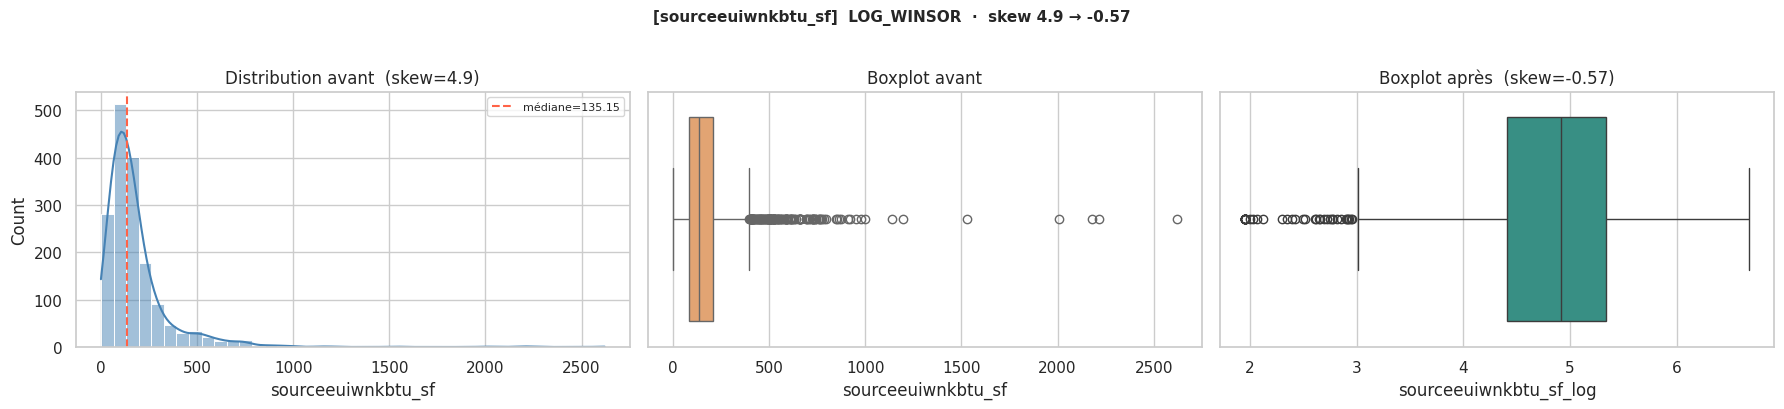

  [numberoffloors]  skew 6.0 - 1.29  |  winsor log [0.693 - 3.625]  |  col : numberoffloors_log


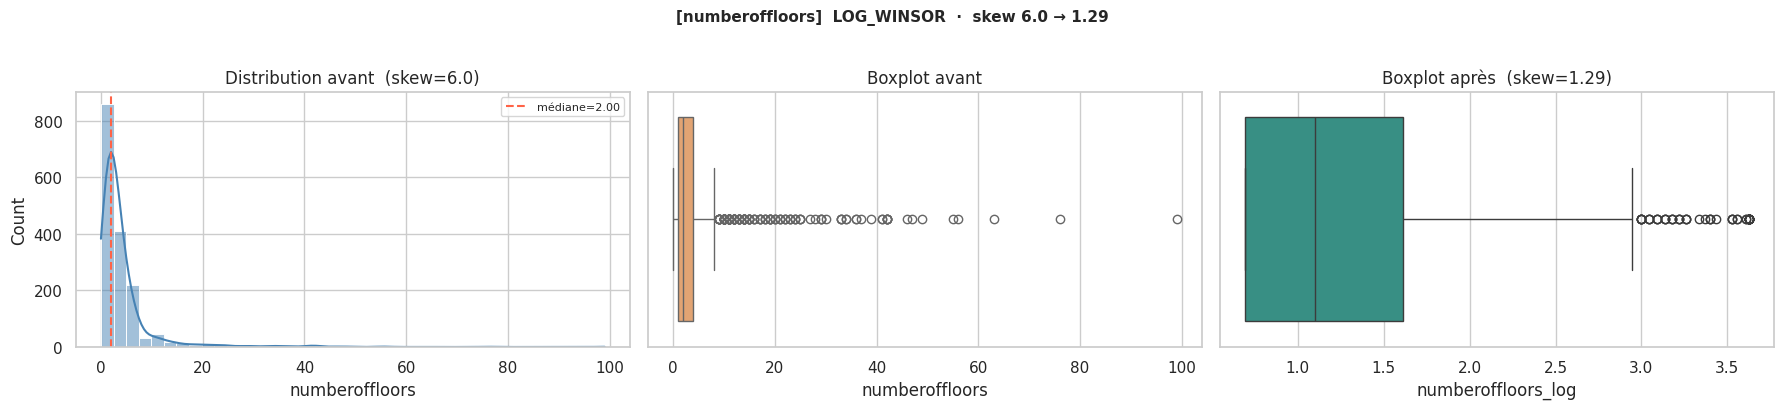

  [ghgemissionsintensity]  skew 4.7 - 1.04  |  winsor log [0.034 - 2.493]  |  col : ghgemissionsintensity_log


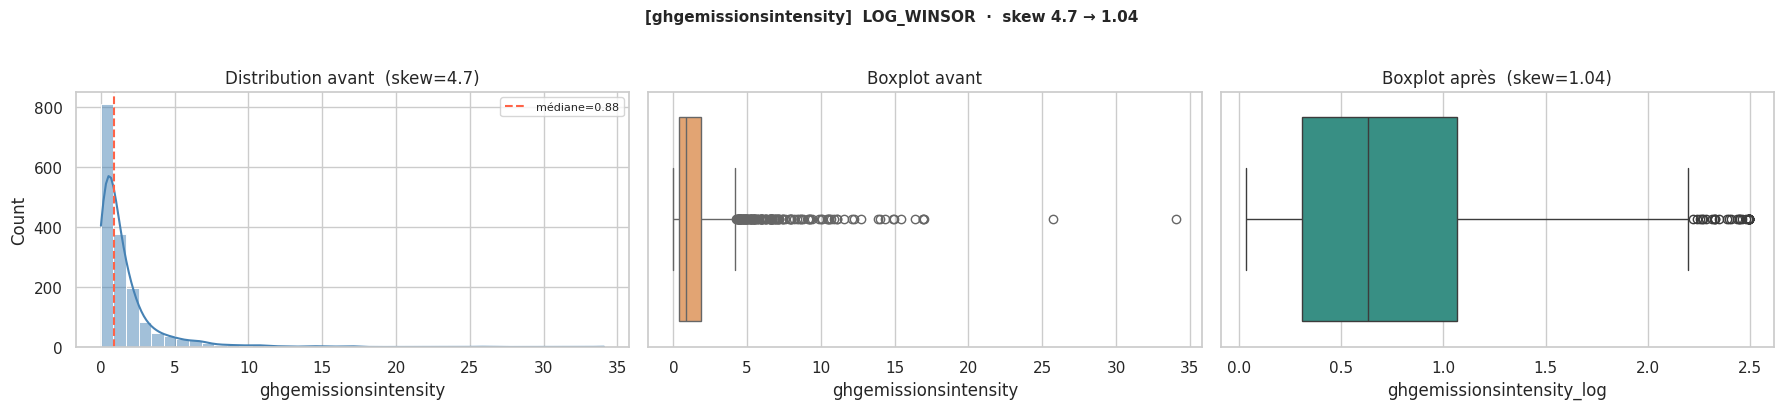

  [secondlargestpropertyusetypegfa]  skew 3.8 - -1.98  |  winsor log [0.000 - 12.727]  |  col : secondlargestpropertyusetypegfa_log


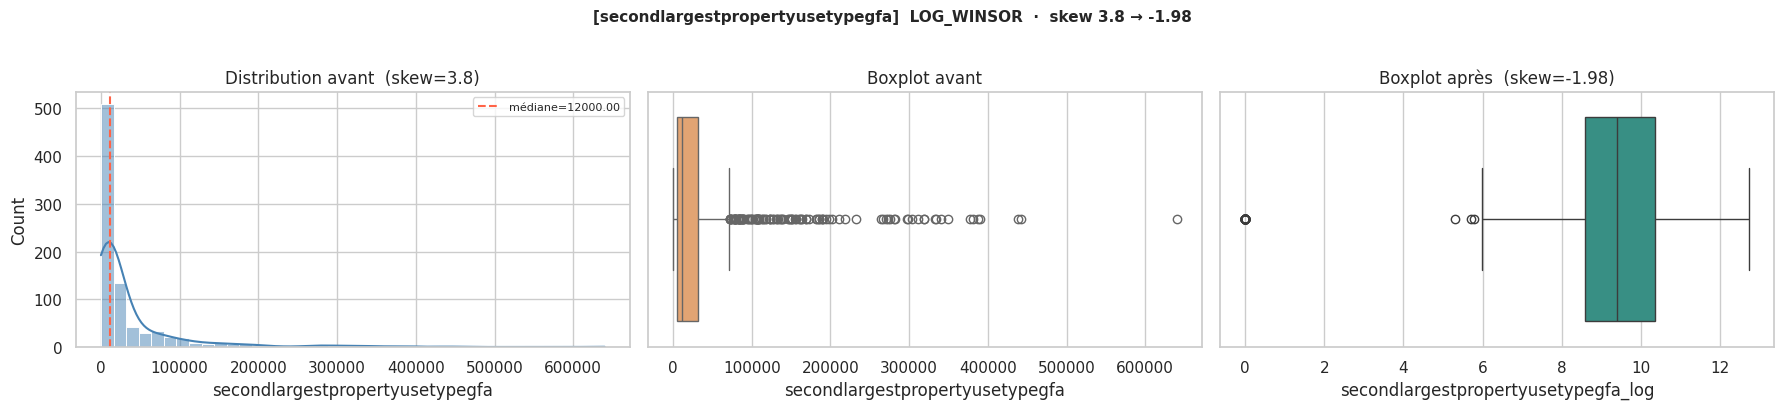


RAPPORT LOG_WINSOR :


Colonne originale                         Colonne _log  \
0                 numberofbuildings                numberofbuildings_log   
1         largestpropertyusetypegfa        largestpropertyusetypegfa_log   
2                  naturalgastherms                 naturalgastherms_log   
3                    naturalgaskbtu                   naturalgaskbtu_log   
4                   electricitykbtu                  electricitykbtu_log   
5                    electricitykwh                   electricitykwh_log   
6              propertygfabuildings             propertygfabuildings_log   
7                      steamusekbtu                     steamusekbtu_log   
8                  propertygfatotal                 propertygfatotal_log   
9               siteenergyusewnkbtu              siteenergyusewnkbtu_log   
10   thirdlargestpropertyusetypegfa   thirdlargestpropertyusetypegfa_log   
11               propertygfaparking               propertygfaparking_log   
12                 sourceeuikbtu_sf                 sourceeuikbtu_sf_log   
13               sourceeuiwnkbtu_sf               sourceeuiwnkbtu_sf_log   
14                   numberoffloors                   numberoffloors_log   
15            ghgemissionsintensity            ghgemissionsintensity_log   
16  secondlargestpropertyusetypegfa  secondlargestpropertyusetypegfa_log   

    Skew avant  Skew après log+winsor  
0       32.300                  1.610  
1       23.400                  0.790  
2       22.000                 -0.710  
3       22.000                 -0.840  
4       20.800                  0.240  
5       20.800                  0.240  
6       21.900                  1.050  
7       19.000                  3.440  
8       19.300                  0.990  
9       11.300                  0.110  
10       7.600                 -2.190  
11       5.200                  1.540  
12       5.000                 -0.260  
13       4.900                 -0.570  
14       6.000                  1.290  
15       4.700                  1.040  
16       3.800                 -1.980

In [21]:

log_report = []

for col in LOG_WINSOR_FEATURES:
    if col not in df.columns:
        print(f'  [{col}]  absent - ignoré')
        continue

    before  = df[col].dropna()
    log_col = f'{col}_log'

    # 1. log1p
    df[log_col] = np.log1p(df[col].clip(lower=0))

    # 2. Winsorisation sur la version log
    lv = df[log_col].quantile(WINSOR_LOW)
    hv = df[log_col].quantile(WINSOR_HIGH)
    df[log_col] = df[log_col].clip(lower=lv, upper=hv)

    skew_after = df[log_col].skew()

    print(f'  [{col}]  skew {before.skew():.1f} - {skew_after:.2f}  |  '
          f'winsor log [{lv:.3f} - {hv:.3f}]  |  col : {log_col}')

    plot_before_after(
        col, before, df[log_col],
        title=f'[{col}]  LOG_WINSOR  ·  skew {before.skew():.1f} → {skew_after:.2f}'
    )

    log_report.append({
        'Colonne originale'   : col,
        'Colonne _log'        : log_col,
        'Skew avant'          : round(before.skew(), 1),
        'Skew après log+winsor': round(skew_after, 2),
    })

print()
print('RAPPORT LOG_WINSOR :')
display(pd.DataFrame(log_report))

# etape3

---
##  1 — Distribution des targets

**Objectif :** montrer visuellement pourquoi `log1p(y)` est obligatoire pour la modélisation.
On compare la distribution brute (ce qu'on a) vs log-transformée (ce que verra le modèle).

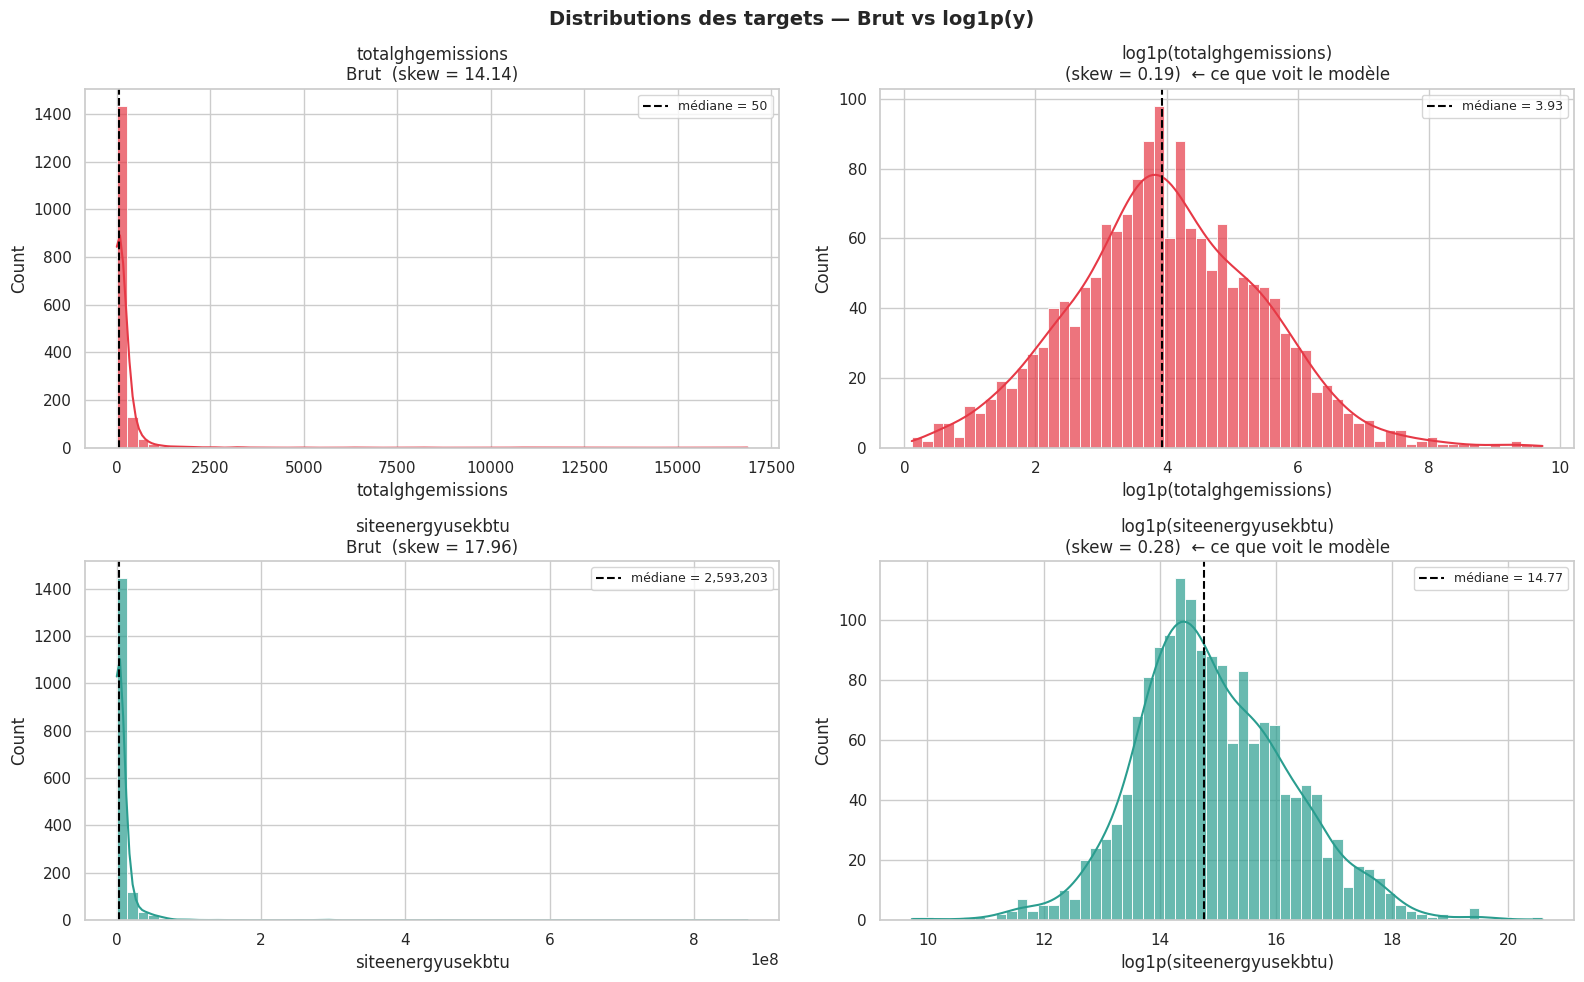

RÉSUMÉ TARGETS :
  Target                                  Min      Médiane             Max  Skew brut   Skew log
  ----------------------------------------------------------------------------------
  totalghgemissions                       0.1         49.8        16,871.0      14.14       0.19
  siteenergyusekbtu                  16,808.9  2,593,202.8   873,923,712.0      17.96       0.28


In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Distributions des targets — Brut vs log1p(y)',
             fontsize=14, fontweight='bold')

targets = [TARGET_CO2, TARGET_ENERGY]
colors  = ['#e63946', '#2a9d8f']

for row, (col, color) in enumerate(zip(targets, colors)):
    data     = df[col].dropna()
    data_log = np.log1p(data)

    # Distribution brute
    sns.histplot(data, kde=True, ax=axes[row, 0], color=color, bins=60, alpha=0.7)
    axes[row, 0].axvline(data.median(), color='black', linestyle='--', lw=1.5,
                         label=f'médiane = {data.median():,.0f}')
    axes[row, 0].set_title(f'{col}\nBrut  (skew = {data.skew():.2f})')
    axes[row, 0].legend(fontsize=9)
    axes[row, 0].set_xlabel(col)

    # Distribution log-transformée
    sns.histplot(data_log, kde=True, ax=axes[row, 1], color=color, bins=60, alpha=0.7)
    axes[row, 1].axvline(data_log.median(), color='black', linestyle='--', lw=1.5,
                         label=f'médiane = {data_log.median():.2f}')
    axes[row, 1].set_title(f'log1p({col})\n(skew = {data_log.skew():.2f})  ← ce que voit le modèle')
    axes[row, 1].legend(fontsize=9)
    axes[row, 1].set_xlabel(f'log1p({col})')

plt.tight_layout()
plt.show()

print('RÉSUMÉ TARGETS :')
print(f'  {"Target":<30} {"Min":>12} {"Médiane":>12} {"Max":>15} {"Skew brut":>10} {"Skew log":>10}')
print('  ' + '-'*82)
for col in targets:
    d = df[col].dropna()
    print(f'  {col:<30} {d.min():>12,.1f} {d.median():>12,.1f} '
          f'{d.max():>15,.1f} {d.skew():>10.2f} {np.log1p(d).skew():>10.2f}')

---
##2 — Analyse univariée des variables numériques clés

On analyse les variables structurelles les plus importantes pour la prédiction :
surface, étages, score Energy Star, et les versions `_log` des consommations.

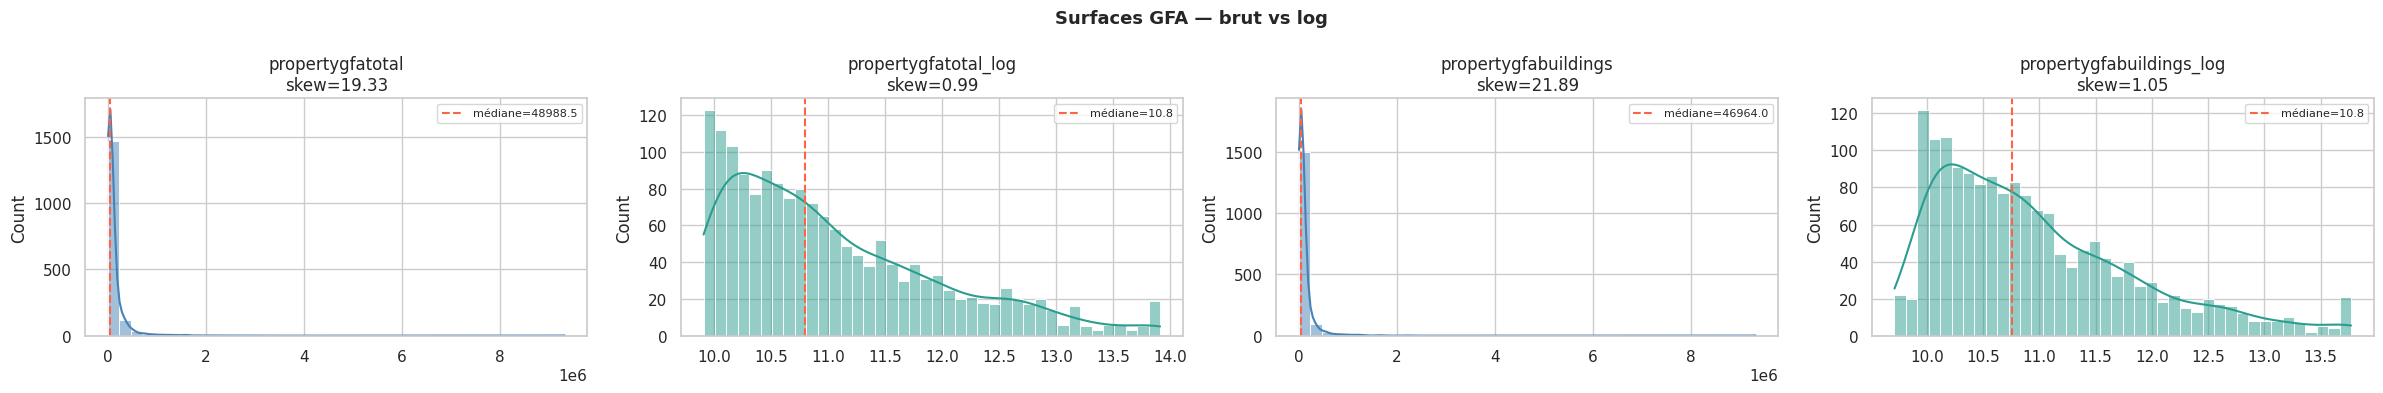

In [23]:
# ── Surfaces (GFA) ────────────────────────────────────────────────────────────
gfa_vars = ['propertygfatotal', 'propertygfatotal_log',
            'propertygfabuildings', 'propertygfabuildings_log']
gfa_vars = [c for c in gfa_vars if c in df.columns]

fig, axes = plt.subplots(1, len(gfa_vars), figsize=(6*len(gfa_vars), 4))
fig.suptitle('Surfaces GFA — brut vs log', fontsize=13, fontweight='bold')

for i, col in enumerate(gfa_vars):
    data = df[col].dropna()
    sns.histplot(data, kde=True, ax=axes[i], bins=40,
                 color='steelblue' if '_log' not in col else '#2a9d8f')
    axes[i].axvline(data.median(), color='tomato', linestyle='--', lw=1.5,
                    label=f'médiane={data.median():.1f}')
    axes[i].set_title(f'{col}\nskew={data.skew():.2f}')
    axes[i].legend(fontsize=8)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

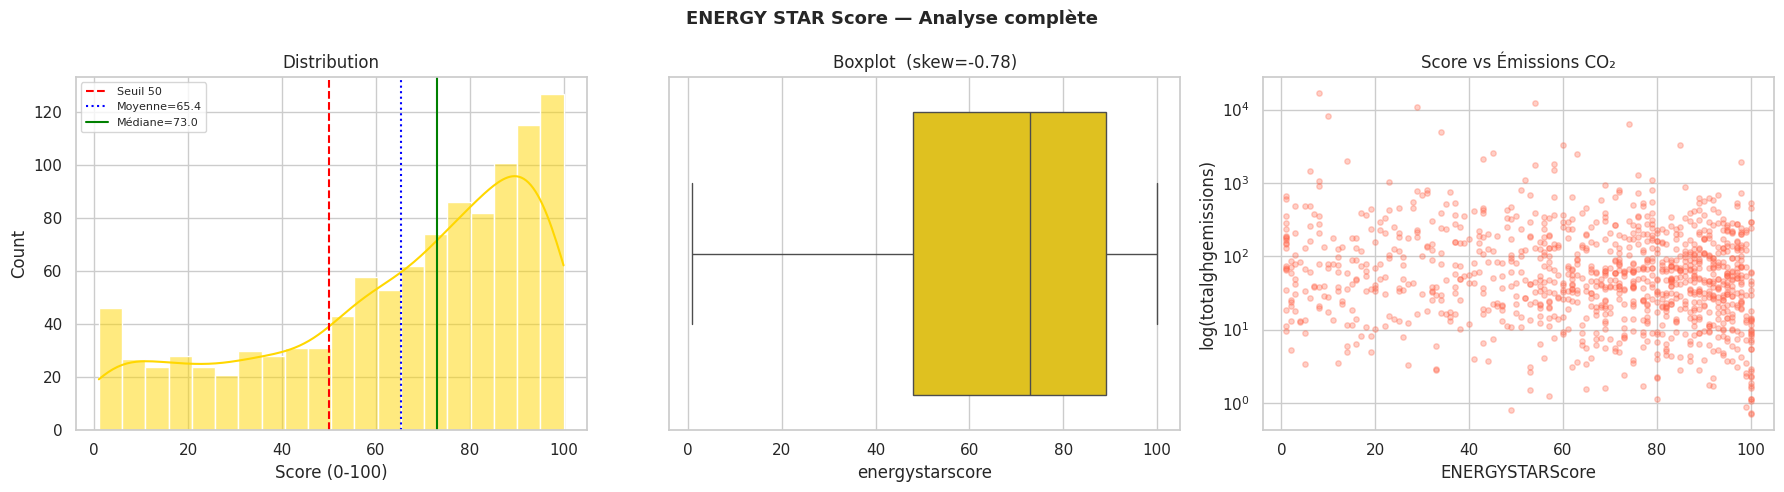

Moyenne   : 65.4
Médiane   : 73.0
Complétude: 66.2%  (557 valeurs manquantes)


In [24]:
# ── Energy Star Score ─────────────────────────────────────────────────────────
col  = 'energystarscore'
data = df[col].dropna()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('ENERGY STAR Score — Analyse complète', fontsize=13, fontweight='bold')

# Distribution
sns.histplot(data, bins=20, ax=axes[0], color='gold', kde=True, edgecolor='white')
axes[0].axvline(50,           color='red',    linestyle='--', lw=1.5, label='Seuil 50')
axes[0].axvline(data.mean(),  color='blue',   linestyle=':',  lw=1.5,
                label=f'Moyenne={data.mean():.1f}')
axes[0].axvline(data.median(),color='green',  linestyle='-',  lw=1.5,
                label=f'Médiane={data.median():.1f}')
axes[0].set_title('Distribution')
axes[0].set_xlabel('Score (0-100)')
axes[0].legend(fontsize=8)

# Boxplot
sns.boxplot(x=data, ax=axes[1], color='gold')
axes[1].set_title(f'Boxplot  (skew={data.skew():.2f})')

# Relation score vs CO2
axes[2].scatter(df[col], df[TARGET_CO2], alpha=0.3, color='tomato', s=15)
axes[2].set_yscale('log')
axes[2].set_xlabel('ENERGYSTARScore')
axes[2].set_ylabel(f'log({TARGET_CO2})')
axes[2].set_title('Score vs Émissions CO₂')

plt.tight_layout()
plt.show()

print(f'Moyenne   : {data.mean():.1f}')
print(f'Médiane   : {data.median():.1f}')
print(f'Complétude: {len(data)/len(df)*100:.1f}%  ({df[col].isna().sum()} valeurs manquantes)')

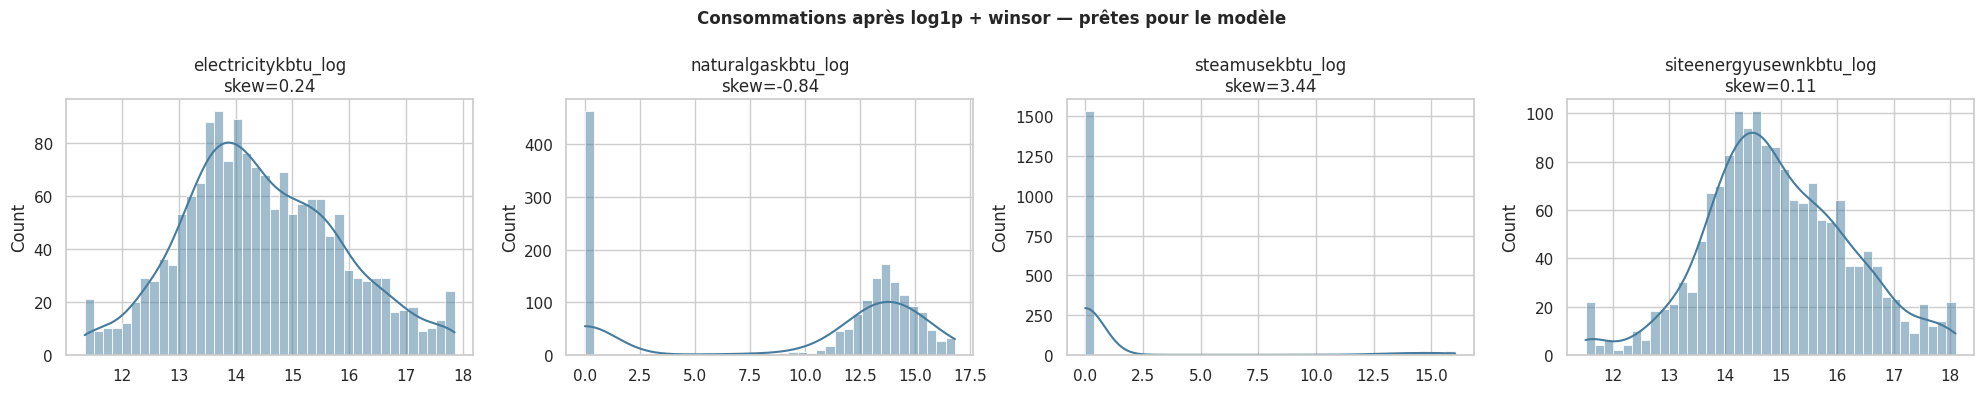

In [25]:
# ── Consommations _log (version prête pour le modèle) ─────────────────────────
conso_log = ['electricitykbtu_log', 'naturalgaskbtu_log',
             'steamusekbtu_log', 'siteenergyusewnkbtu_log']
conso_log = [c for c in conso_log if c in df.columns]

fig, axes = plt.subplots(1, len(conso_log), figsize=(5*len(conso_log), 4))
fig.suptitle('Consommations après log1p + winsor — prêtes pour le modèle',
             fontsize=12, fontweight='bold')

for i, col in enumerate(conso_log):
    data = df[col].dropna()
    sns.histplot(data, kde=True, ax=axes[i], bins=40, color='#457b9d', edgecolor='white')
    axes[i].set_title(f'{col}\nskew={data.skew():.2f}')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

---
## 3 — Analyse des variables catégorielles

On analyse les types de bâtiments et leur relation avec les targets.

/tmp/ipython-input-848708332.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='primarypropertytype', order=order,


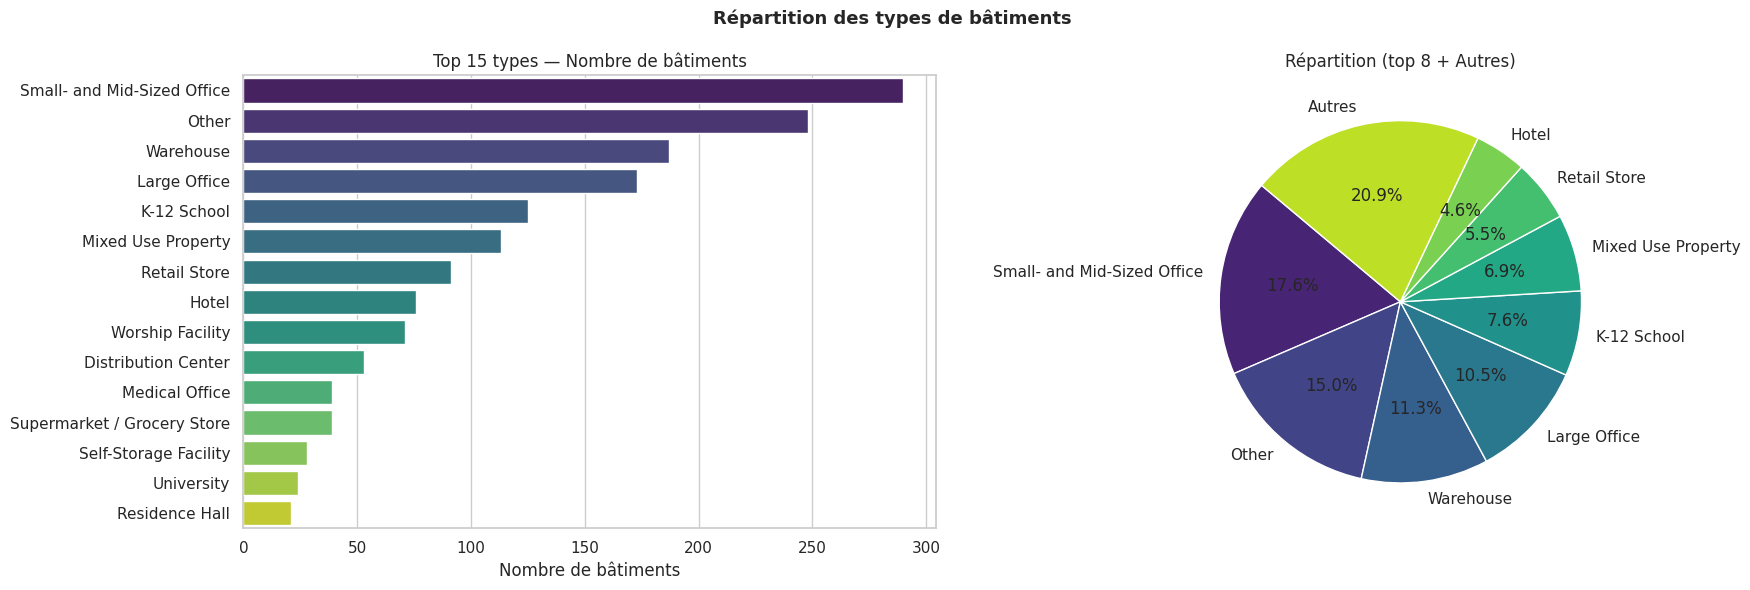

In [26]:
# ── Répartition PrimaryPropertyType ──────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Répartition des types de bâtiments', fontsize=13, fontweight='bold')

order = df['primarypropertytype'].value_counts().head(15).index
sns.countplot(data=df, y='primarypropertytype', order=order,
              ax=axes[0], palette='viridis')
axes[0].set_title('Top 15 types — Nombre de bâtiments')
axes[0].set_xlabel('Nombre de bâtiments')
axes[0].set_ylabel('')

# Camembert top 8
counts = df['primarypropertytype'].value_counts().head(8)
other  = df['primarypropertytype'].value_counts().iloc[8:].sum()
counts['Autres'] = other
axes[1].pie(counts, labels=counts.index, autopct='%1.1f%%',
            colors=sns.color_palette('viridis', len(counts)),
            startangle=140)
axes[1].set_title('Répartition (top 8 + Autres)')

plt.tight_layout()
plt.show()

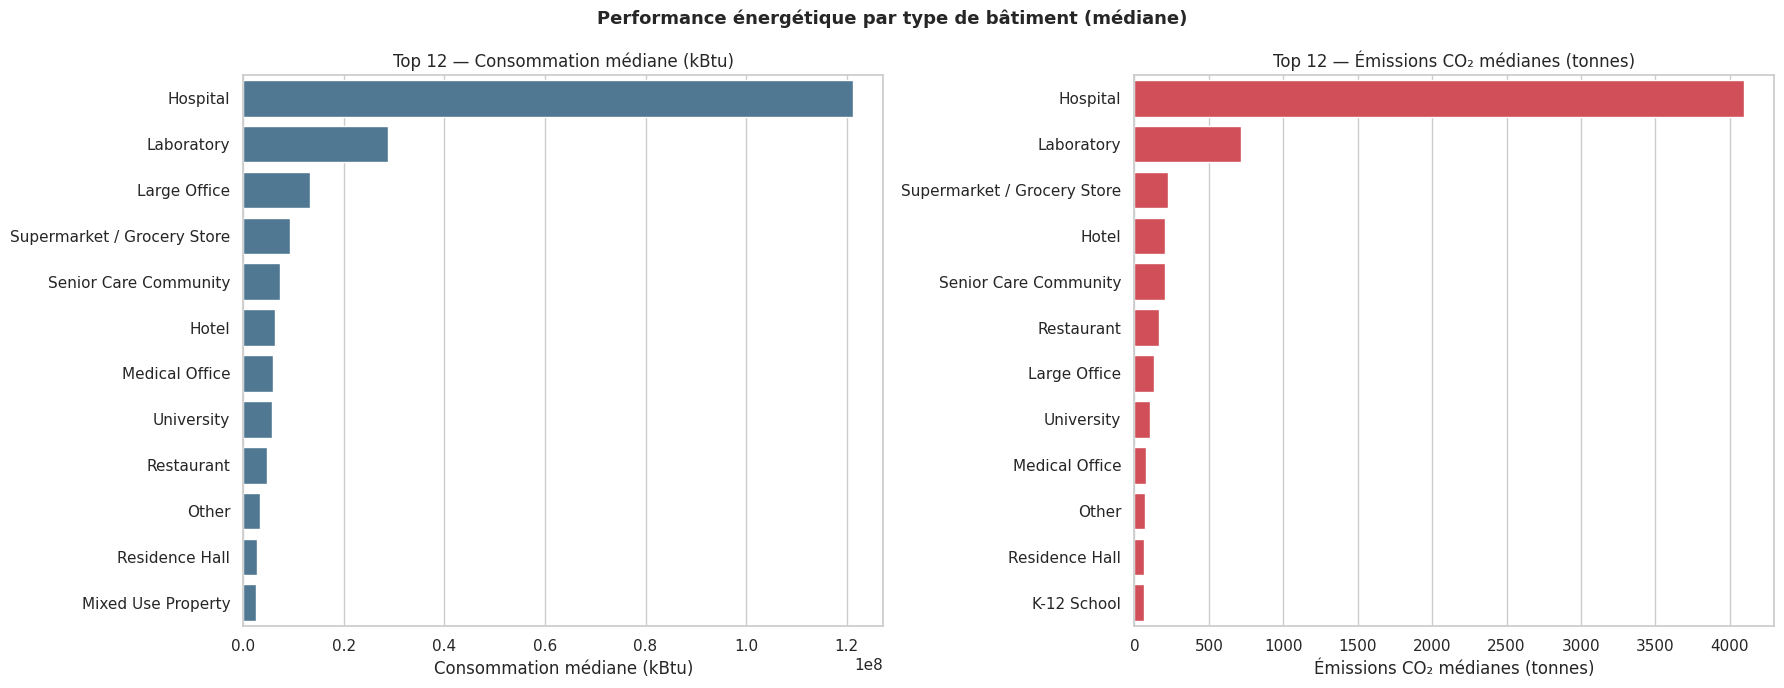

In [27]:
# ── Top types par consommation et émissions médianes ─────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Performance énergétique par type de bâtiment (médiane)',
             fontsize=13, fontweight='bold')

for ax, target, label, color in [
    (axes[0], TARGET_ENERGY, 'Consommation médiane (kBtu)', '#457b9d'),
    (axes[1], TARGET_CO2,    'Émissions CO₂ médianes (tonnes)', '#e63946'),
]:
    top = (df.groupby('primarypropertytype')[target]
             .median().sort_values(ascending=False).head(12))
    sns.barplot(x=top.values, y=top.index, ax=ax, color=color)
    ax.set_title(f'Top 12 — {label}')
    ax.set_xlabel(label)
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

/tmp/ipython-input-828797263.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top8, x='log_co2', y='primarypropertytype',


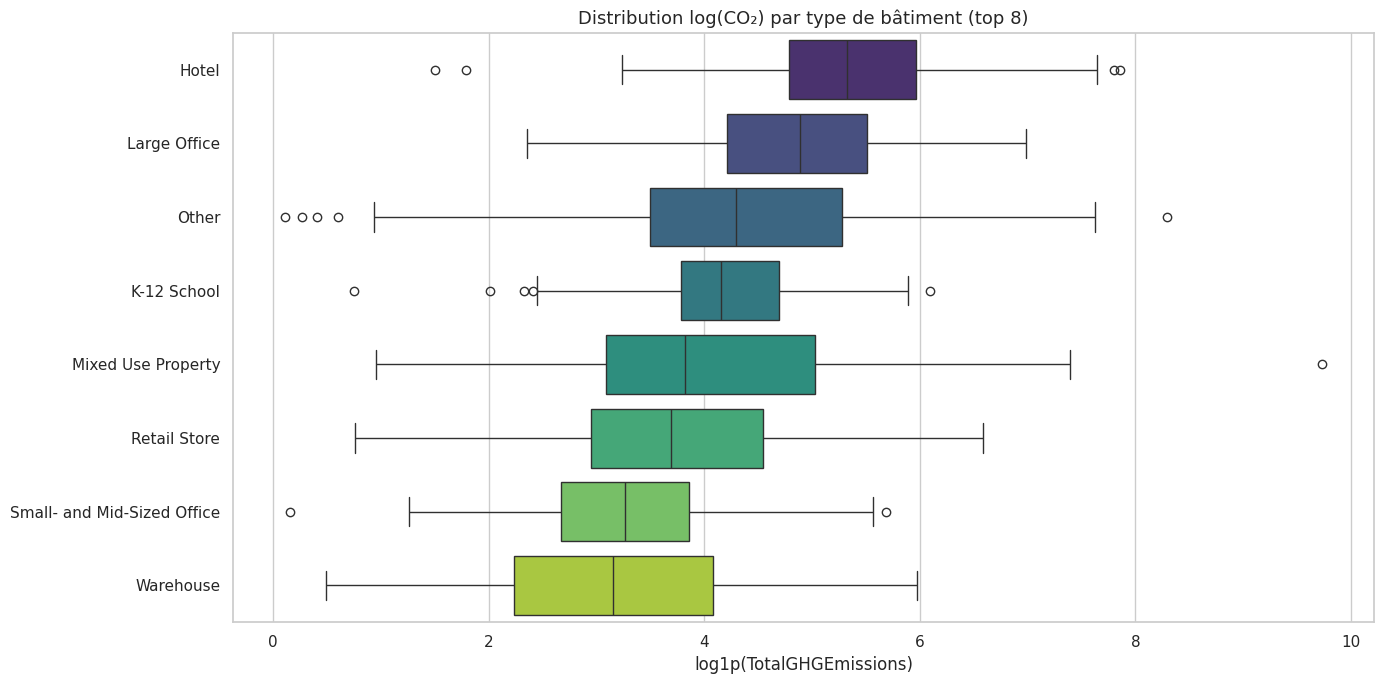

In [28]:
# ── Boxplot émissions CO2 par type (top 8) ────────────────────────────────────
top8_types = df['primarypropertytype'].value_counts().head(8).index
df_top8    = df[df['primarypropertytype'].isin(top8_types)].copy()
df_top8['log_co2'] = np.log1p(df_top8[TARGET_CO2])

plt.figure(figsize=(14, 7))
order_box = df_top8.groupby('primarypropertytype')['log_co2'].median().sort_values(ascending=False).index
sns.boxplot(data=df_top8, x='log_co2', y='primarypropertytype',
            order=order_box, palette='viridis')
plt.title('Distribution log(CO₂) par type de bâtiment (top 8)', fontsize=13)
plt.xlabel('log1p(TotalGHGEmissions)')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [29]:
# ── Cohérence usage principal vs surface principale ───────────────────────────
mismatch = df[df['primarypropertytype'] != df['largestpropertyusetype']].shape[0]
pct = mismatch / len(df) * 100
print(f'Bâtiments où usage principal ≠ usage de plus grande surface : {mismatch} ({pct:.1f}%)')
print('→ Ces bâtiments ont une mixité d\'usage — important pour le feature engineering')

Bâtiments où usage principal ≠ usage de plus grande surface : 1025 (62.2%)
→ Ces bâtiments ont une mixité d'usage — important pour le feature engineering


---
##  4 — Analyse temporelle

Relation entre l'année de construction et la performance énergétique.
Hypothèse : les bâtiments anciens consomment plus (avant les normes énergétiques).

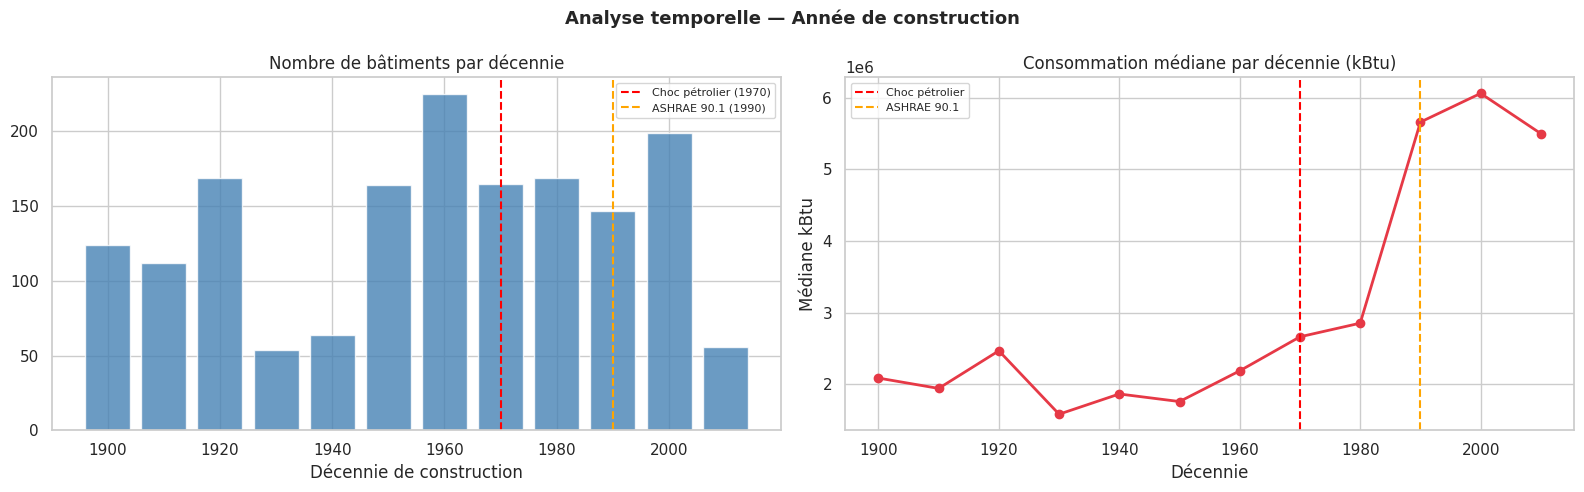

In [30]:
# ── Distribution des années de construction ───────────────────────────────────
valid = df[(df['yearbuilt'] > 1850) & (df['yearbuilt'] <= 2016)]
decades = (valid['yearbuilt'] // 10) * 10

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Analyse temporelle — Année de construction', fontsize=13, fontweight='bold')

# Nombre de bâtiments par décennie
dc = decades.value_counts().sort_index()
axes[0].bar(dc.index, dc.values, width=8, color='steelblue', alpha=0.8, edgecolor='white')
axes[0].axvline(1970, color='red',    linestyle='--', lw=1.5, label='Choc pétrolier (1970)')
axes[0].axvline(1990, color='orange', linestyle='--', lw=1.5, label='ASHRAE 90.1 (1990)')
axes[0].set_title('Nombre de bâtiments par décennie')
axes[0].set_xlabel('Décennie de construction')
axes[0].legend(fontsize=8)

# Consommation médiane par décennie
df_valid = df[(df['yearbuilt'] > 1850) & (df['yearbuilt'] <= 2016)].copy()
df_valid['decade'] = (df_valid['yearbuilt'] // 10) * 10
dec_median = df_valid.groupby('decade')[TARGET_ENERGY].median()

axes[1].plot(dec_median.index, dec_median.values, color='#e63946', marker='o', lw=2)
axes[1].axvline(1970, color='red',    linestyle='--', lw=1.5, label='Choc pétrolier')
axes[1].axvline(1990, color='orange', linestyle='--', lw=1.5, label='ASHRAE 90.1')
axes[1].set_title('Consommation médiane par décennie (kBtu)')
axes[1].set_xlabel('Décennie')
axes[1].set_ylabel('Médiane kBtu')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

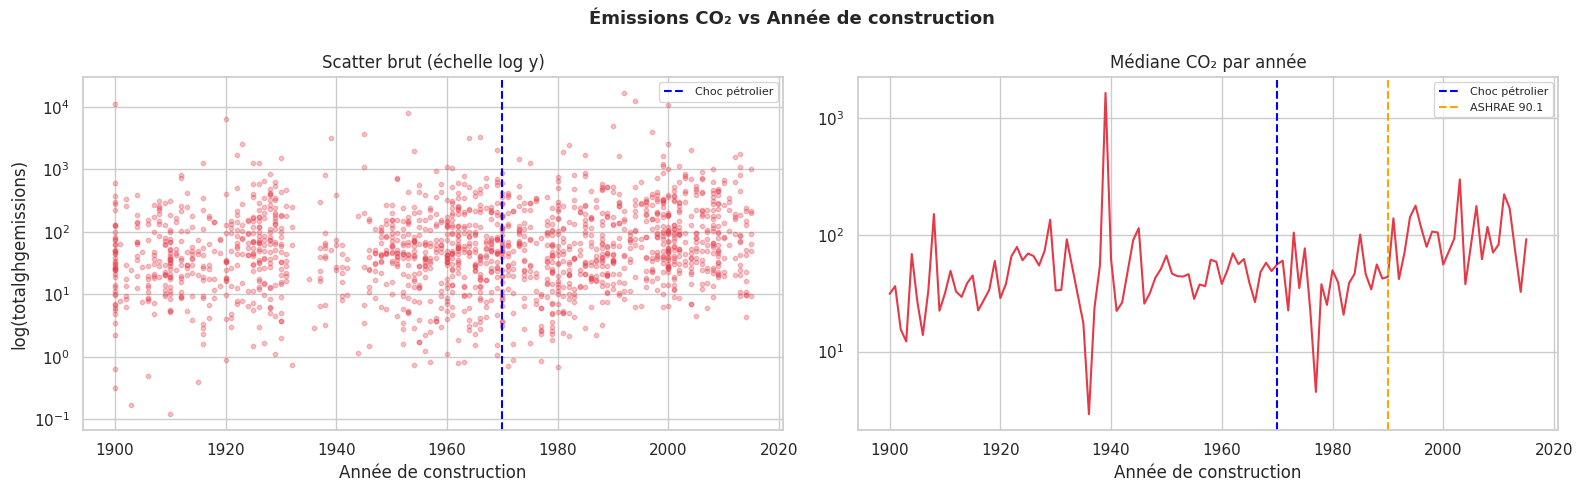

Médiane par ère de construction :


totalghgemissions  siteenergyusekbtu
construction_era                                             
Historic (<1950)                    43.840        2058532.875
Mid-Century (1950-1980)             47.080        2107743.750
Early Code (1980-2000)              58.480        4515426.500
Modern (2000-2010)                  81.240        6062770.500
Recent (>2010)                      89.800        5475367.000

In [31]:
# ── Émissions CO2 vs Année de construction ────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Émissions CO₂ vs Année de construction', fontsize=13, fontweight='bold')

# Scatter brut
axes[0].scatter(df['yearbuilt'], df[TARGET_CO2],
                alpha=0.3, s=10, color='#e63946')
axes[0].set_yscale('log')
axes[0].axvline(1970, color='blue', linestyle='--', lw=1.5, label='Choc pétrolier')
axes[0].set_title('Scatter brut (échelle log y)')
axes[0].set_xlabel('Année de construction')
axes[0].set_ylabel(f'log({TARGET_CO2})')
axes[0].legend(fontsize=8)

# Médiane glissante
df_yr = df_valid.groupby('yearbuilt')[TARGET_CO2].median().reset_index()
df_yr = df_yr.sort_values('yearbuilt')
axes[1].plot(df_yr['yearbuilt'], df_yr[TARGET_CO2], color='#e63946', lw=1.5)
axes[1].axvline(1970, color='blue', linestyle='--', lw=1.5, label='Choc pétrolier')
axes[1].axvline(1990, color='orange', linestyle='--', lw=1.5, label='ASHRAE 90.1')
axes[1].set_yscale('log')
axes[1].set_title('Médiane CO₂ par année')
axes[1].set_xlabel('Année de construction')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Analyse par ère
df['construction_era'] = pd.cut(
    df['yearbuilt'],
    bins=[-np.inf, 1950, 1980, 2000, 2010, np.inf],
    labels=['Historic (<1950)', 'Mid-Century (1950-1980)',
            'Early Code (1980-2000)', 'Modern (2000-2010)', 'Recent (>2010)']
)

era_stats = df.groupby('construction_era', observed=True)[[TARGET_CO2, TARGET_ENERGY]].median()
print('Médiane par ère de construction :')
display(era_stats)

---
##  5 — Analyse géographique

Deux visualisations : carte scatter matplotlib (statique) + heatmap Folium (interactive).

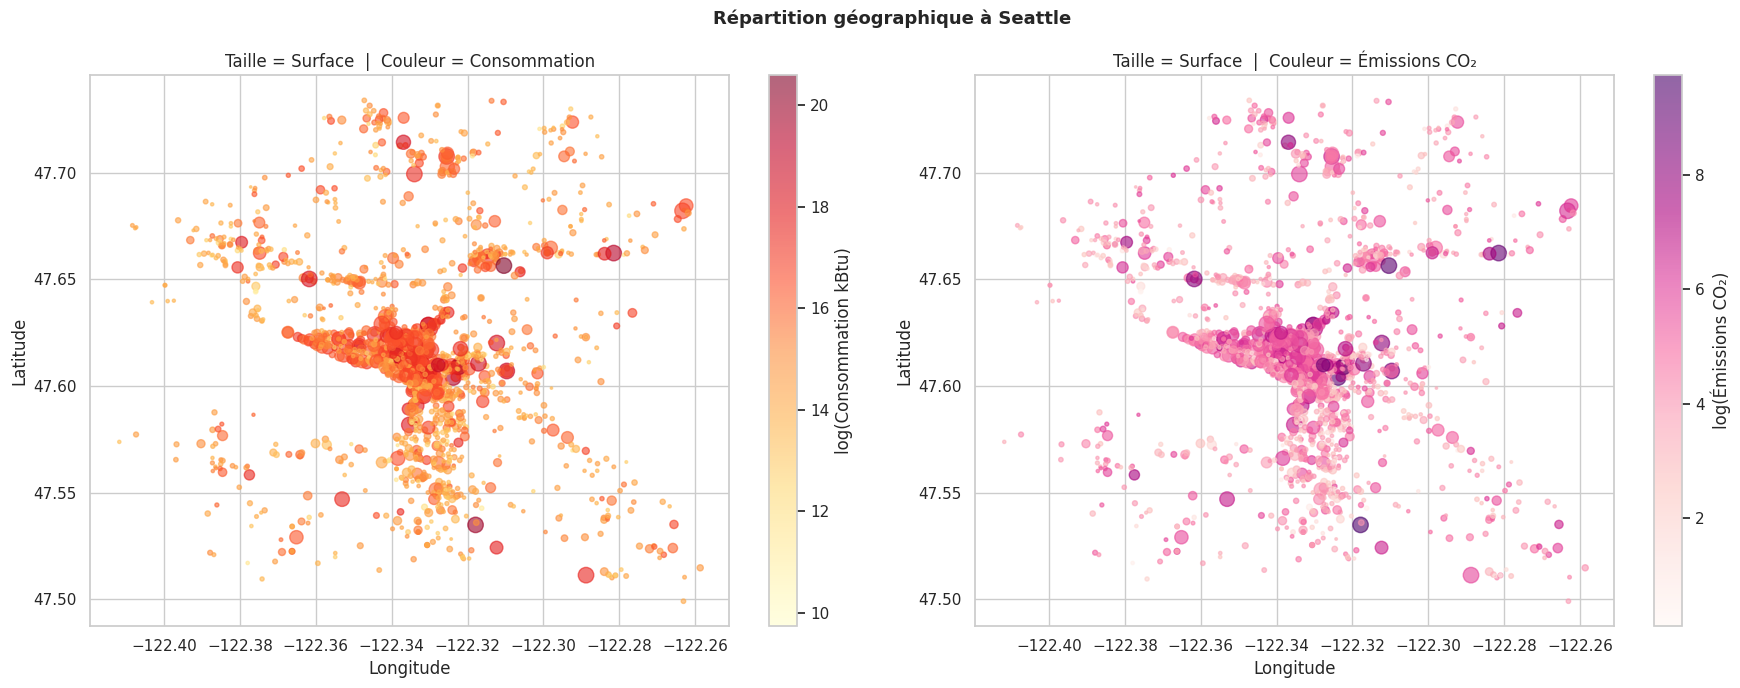

In [32]:
# ── Carte scatter : taille = surface, couleur = consommation ─────────────────
df_geo = df.dropna(subset=['latitude', 'longitude', TARGET_ENERGY]).copy()

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Répartition géographique à Seattle', fontsize=13, fontweight='bold')

# Consommation
sc1 = axes[0].scatter(
    df_geo['longitude'], df_geo['latitude'],
    c=np.log1p(df_geo[TARGET_ENERGY]),
    cmap='YlOrRd', alpha=0.6,
    s=df_geo['propertygfatotal'].clip(upper=500_000) / 4000
)
plt.colorbar(sc1, ax=axes[0], label='log(Consommation kBtu)')
axes[0].set_title('Taille = Surface  |  Couleur = Consommation')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Émissions CO2
sc2 = axes[1].scatter(
    df_geo['longitude'], df_geo['latitude'],
    c=np.log1p(df_geo[TARGET_CO2]),
    cmap='RdPu', alpha=0.6,
    s=df_geo['propertygfatotal'].clip(upper=500_000) / 4000
)
plt.colorbar(sc2, ax=axes[1], label='log(Émissions CO₂)')
axes[1].set_title('Taille = Surface  |  Couleur = Émissions CO₂')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

In [33]:
# ── Carte de chaleur interactive Folium ───────────────────────────────────────
m = folium.Map(
    location=[df_geo['latitude'].mean(), df_geo['longitude'].mean()],
    zoom_start=12,
    tiles='cartodbpositron'
)

heat_data = [
    [row['latitude'], row['longitude'], row[TARGET_ENERGY]]
    for _, row in df_geo.iterrows()
]
HeatMap(heat_data, radius=15, blur=10, max_zoom=13).add_to(m)

folium.LayerControl().add_to(m)

MAP_PATH = '/content/drive/MyDrive/D-CLIC/projet_energisight/data/energy_heatmap.html'
m.save(MAP_PATH)
print(f'Carte sauvegardée : {MAP_PATH}')
display(m)

Carte sauvegardée : /content/drive/MyDrive/D-CLIC/projet_energisight/data/energy_heatmap.html


/tmp/ipython-input-2305380132.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_neigh['Consommation médiane (kBtu)'],


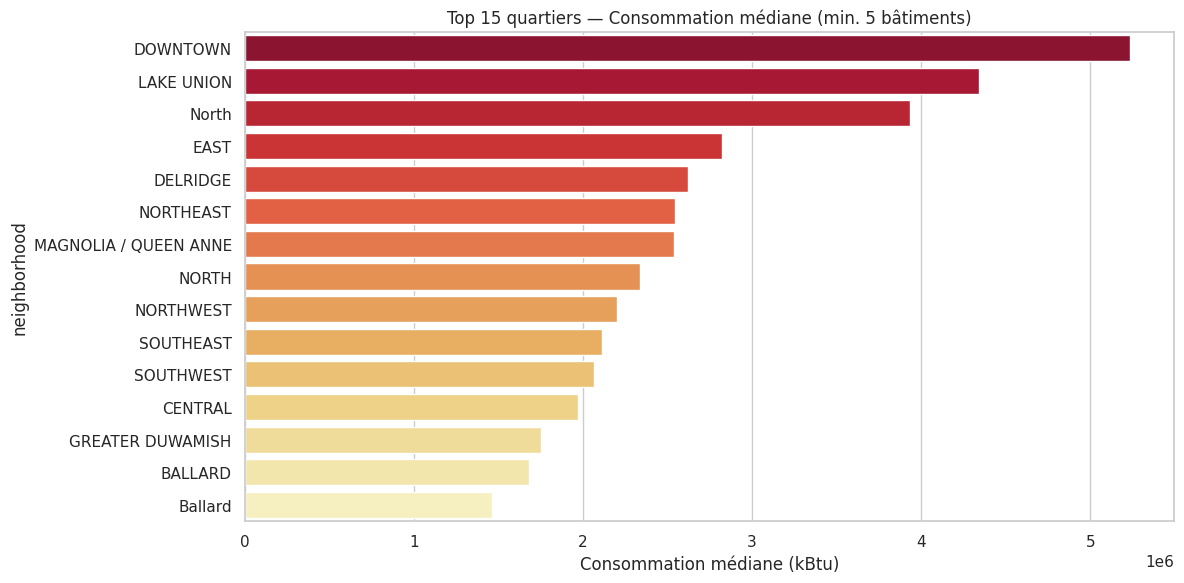


Top 15 quartiers :


Consommation médiane (kBtu)  N bâtiments
neighborhood                                                   
DOWNTOWN                               5233553.500          359
LAKE UNION                             4342597.000          147
North                                  3936421.500            9
EAST                                   2823184.000          121
DELRIDGE                               2619088.500           41
NORTHEAST                              2545405.000          127
MAGNOLIA / QUEEN ANNE                  2538071.500          148
NORTH                                  2335914.250           56
NORTHWEST                              2197598.000           80
SOUTHEAST                              2108861.750           45
SOUTHWEST                              2067278.062           40
CENTRAL                                1967476.375           47
GREATER DUWAMISH                       1749531.750          346
BALLARD                                1682431.875           62
Ballard                                1458912.250            6

In [34]:
# ── Top quartiers par consommation ───────────────────────────────────────────
top_neigh = (df.groupby('neighborhood')[TARGET_ENERGY]
               .agg(['median', 'count'])
               .rename(columns={'median': 'Consommation médiane (kBtu)', 'count': 'N bâtiments'})
               .query('`N bâtiments` >= 5')
               .sort_values('Consommation médiane (kBtu)', ascending=False)
               .head(15))

plt.figure(figsize=(12, 6))
sns.barplot(x=top_neigh['Consommation médiane (kBtu)'],
            y=top_neigh.index, palette='YlOrRd_r')
plt.title('Top 15 quartiers — Consommation médiane (min. 5 bâtiments)', fontsize=12)
plt.xlabel('Consommation médiane (kBtu)')
plt.tight_layout()
plt.show()

print('\nTop 15 quartiers :')
display(top_neigh)

## ÉTAPE 4 — Imputation des NaN + Feature Engineering

**Stratégie NaN par colonne :**

| Colonne | NaN | Stratégie |
|---|---|---|
| `comments`, `yearsenergystarcertified`, `outlier` | 94-100% | Supprimées |
| `thirdlargest...gfa` | 78% | → 0 (absent = pas d'usage tertiaire) |
| `secondlargest...gfa` | 48% | → 0 (absent = pas d'usage secondaire) |
| `energystarscore` | 33.8% | Médiane par type de bâtiment + flag `energystar_missing` |
| `largestpropertyusetypegfa` | 0.2% | Médiane globale (4 lignes) |
| `largestpropertyusetype` | 0.2% | Mode global |
| `zipcode` | 1% | Mode par quartier |
| `siteeuiwnkbtu_sf`, `siteenergyusewnkbtu` | 0.1% | Médiane globale (1 ligne) |

---
###  Suppression des colonnes inexploitables

In [35]:
# Colonnes à supprimer — trop vides ou non informatives
COLS_DROP = [
    'comments',                    # 100% vide
    'yearsenergystarcertified',    # 94% vide
    'outlier',                     # 99% vide, flag déjà créé à l'étape 2
    'datayear',                    # constante (2016)
    'city',                        # constante (Seattle)
    'state',                       # constante (WA)
    'osebuildingid',               # identifiant, pas un prédicteur
    'taxparcelidentificationnumber',# identifiant
    'propertyname',                # texte libre
    'address',                     # texte libre
    'listofallpropertyusetypes',   # texte libre, redondant
    'secondlargestpropertyusetype',# texte, GFA gardé
    'thirdlargestpropertyusetype', # texte, GFA gardé
]

cols_dropped = [c for c in COLS_DROP if c in df.columns]
df = df.drop(columns=cols_dropped)

print(f'Colonnes supprimées : {len(cols_dropped)}')
print(f'Dataset : {df.shape[0]} lignes × {df.shape[1]} colonnes')

Colonnes supprimées : 13
Dataset : 1648 lignes × 52 colonnes


---
###Imputation des NaN

**Ordre :** on impute d'abord les variables simples (1-4 NaN), puis `energystarscore` qui
nécessite une médiane par groupe — et on crée le flag **avant** l'imputation pour
ne pas perdre l'information que la valeur était manquante.

In [36]:
print('━━━ IMPUTATION DES NaN ━━━')
print()

# ── 1. GFA usages secondaire et tertiaire → 0
# Logique : NaN signifie que le bâtiment n'a pas d'usage secondaire/tertiaire
# → surface = 0, pas une vraie valeur manquante
for col in ['secondlargestpropertyusetypegfa', 'thirdlargestpropertyusetypegfa']:
    if col in df.columns:
        n = df[col].isna().sum()
        df[col] = df[col].fillna(0)
        print(f'  {col:<40} {n:>4} NaN → 0 (pas d\'usage)')

# ── 2. largestpropertyusetypegfa → médiane globale (4 cas)
if 'largestpropertyusetypegfa' in df.columns:
    n = df['largestpropertyusetypegfa'].isna().sum()
    med = df['largestpropertyusetypegfa'].median()
    df['largestpropertyusetypegfa'] = df['largestpropertyusetypegfa'].fillna(med)
    print(f'  largestpropertyusetypegfa              {n:>4} NaN → médiane ({med:,.0f})')

# ── 3. largestpropertyusetype → mode global (4 cas)
if 'largestpropertyusetype' in df.columns:
    n = df['largestpropertyusetype'].isna().sum()
    mode_val = df['largestpropertyusetype'].mode()[0]
    df['largestpropertyusetype'] = df['largestpropertyusetype'].fillna(mode_val)
    print(f'  largestpropertyusetype                 {n:>4} NaN → mode ("{mode_val}")')

# ── 4. zipcode → mode par quartier (16 cas)
if 'zipcode' in df.columns and 'neighborhood' in df.columns:
    n = df['zipcode'].isna().sum()
    mode_zip = df.groupby('neighborhood')['zipcode'].transform(
        lambda x: x.mode()[0] if not x.mode().empty else df['zipcode'].mode()[0]
    )
    df['zipcode'] = df['zipcode'].fillna(mode_zip)
    print(f'  zipcode                               {n:>4} NaN → mode par quartier')

# ── 5. siteeuiwnkbtu_sf, siteenergyusewnkbtu → médiane globale (1 cas)
for col in ['siteeuiwnkbtu_sf', 'siteenergyusewnkbtu']:
    if col in df.columns:
        n = df[col].isna().sum()
        med = df[col].median()
        df[col] = df[col].fillna(med)
        print(f'  {col:<40} {n:>4} NaN → médiane ({med:.2f})')

# ── 6. energystarscore → IMPORTANT : flag AVANT imputation
# 33.8% manquants — l'absence du score est une information en soi
# (bâtiment non certifié ou non soumis à la certification)
print()
print('  [energystarscore] : 33.8% manquants — stratégie en 2 temps :')

# a. Créer le flag AVANT d'imputer
df['energystar_missing'] = df['energystarscore'].isna().astype(int)
n_missing = df['energystar_missing'].sum()
print(f'    → flag energystar_missing créé : {n_missing} bâtiments sans score')

# b. Imputer par médiane par type de bâtiment
# Pourquoi par type ? Un hôpital et un entrepôt n'ont pas le même profil de score.
median_by_type = df.groupby('primarypropertytype')['energystarscore'].transform('median')
global_median  = df['energystarscore'].median()

# Si le type entier n'a aucun score, on utilise la médiane globale
df['energystarscore'] = df['energystarscore'].fillna(median_by_type).fillna(global_median)
print(f'    → imputé par médiane par type (médiane globale de secours = {global_median:.1f})')

# Vérification
nan_restants = df.isnull().sum()
nan_restants = nan_restants[nan_restants > 0]
print()
if len(nan_restants) == 0:
    print('Aucun NaN restant après imputation')
else:
    print(f'  NaN restants :')
    print(nan_restants)

━━━ IMPUTATION DES NaN ━━━

  secondlargestpropertyusetypegfa           795 NaN → 0 (pas d'usage)
  thirdlargestpropertyusetypegfa           1296 NaN → 0 (pas d'usage)
  largestpropertyusetypegfa                 4 NaN → médiane (43,484)
  largestpropertyusetype                    4 NaN → mode ("Office")
  zipcode                                  0 NaN → mode par quartier
  siteeuiwnkbtu_sf                            1 NaN → médiane (54.30)
  siteenergyusewnkbtu                         1 NaN → médiane (2737986.00)

  [energystarscore] : 33.8% manquants — stratégie en 2 temps :
    → flag energystar_missing créé : 557 bâtiments sans score
    → imputé par médiane par type (médiane globale de secours = 73.0)

  NaN restants :
largestpropertyusetypegfa_log             4
siteenergyusewnkbtu_log                   1
thirdlargestpropertyusetypegfa_log     1296
secondlargestpropertyusetypegfa_log     795
dtype: int64


In [37]:
# ─────────────────────────────────────────────────────────────────────────────
# RECALCUL DES COLONNES _log APRÈS IMPUTATION
# Les colonnes _log ont été créées à l'étape 2 AVANT l'imputation des NaN.
# Les NaN des originaux se sont donc propagés dans les _log.
# On les recalcule maintenant sur les valeurs imputées.
# ─────────────────────────────────────────────────────────────────────────────
print()
print('  Recalcul des colonnes _log après imputation :')

cols_to_relog = [
    'secondlargestpropertyusetypegfa',
    'thirdlargestpropertyusetypegfa',
    'largestpropertyusetypegfa',
    'siteenergyusewnkbtu',
]

for col in cols_to_relog:
    log_col = f'{col}_log'
    if log_col in df.columns and col in df.columns:
        df[log_col] = np.log1p(df[col].clip(lower=0))
        # Reappliquer la winsorisation P1/P99
        lv = df[log_col].quantile(0.01)
        hv = df[log_col].quantile(0.99)
        df[log_col] = df[log_col].clip(lower=lv, upper=hv)
        n_nan = df[log_col].isna().sum()
        print(f'    {log_col:<45} recalculé  (NaN restants : {n_nan})')

# Vérification globale NaN
nan_final = df.isnull().sum()
nan_final = nan_final[nan_final > 0]
print()
if len(nan_final) == 0:
    print(' Aucun NaN restant après imputation + recalcul _log')
else:
    print(f'  NaN restants dans {len(nan_final)} colonnes :')
    print(nan_final)



  Recalcul des colonnes _log après imputation :
    secondlargestpropertyusetypegfa_log           recalculé  (NaN restants : 0)
    thirdlargestpropertyusetypegfa_log            recalculé  (NaN restants : 0)
    largestpropertyusetypegfa_log                 recalculé  (NaN restants : 0)
    siteenergyusewnkbtu_log                       recalculé  (NaN restants : 0)

 Aucun NaN restant après imputation + recalcul _log


---
###Feature Engineering

**Ordre de création :**
1. Flags binaires (uses_steam, uses_gas, has_parking)
2. Âge + ères de construction
3. Ratios de surface
4. Mix énergétique
5. Indice de mixité d'usage
6. Features Energy Star
7. Interactions

In [38]:
print('━━━ FEATURE ENGINEERING ━━━')
n_cols_before = df.shape[1]

# ─────────────────────────────────────────────────────────────────────────────
# 1. FLAGS BINAIRES
# Pourquoi : steamusekbtu est à 93% zéro → quasi-binaire
#            naturalgaskbtu est à 28% zéro → information structurelle
# ─────────────────────────────────────────────────────────────────────────────
df['uses_steam']  = (df['steamusekbtu'].fillna(0)  > 0).astype(int)
df['uses_gas']    = (df['naturalgaskbtu'].fillna(0) > 0).astype(int)
df['has_parking'] = (df['propertygfaparking'] > 0).astype(int)

print(f'\n1. FLAGS BINAIRES :')
print(f'   uses_steam  : {df["uses_steam"].sum()} bâtiments utilisent la vapeur '
      f'({df["uses_steam"].mean()*100:.1f}%)')
print(f'   uses_gas    : {df["uses_gas"].sum()} bâtiments utilisent le gaz '
      f'({df["uses_gas"].mean()*100:.1f}%)')
print(f'   has_parking : {df["has_parking"].sum()} bâtiments ont un parking '
      f'({df["has_parking"].mean()*100:.1f}%)')

━━━ FEATURE ENGINEERING ━━━

1. FLAGS BINAIRES :
   uses_steam  : 114 bâtiments utilisent la vapeur (6.9%)
   uses_gas    : 1185 bâtiments utilisent le gaz (71.9%)
   has_parking : 333 bâtiments ont un parking (20.2%)


In [39]:
# ─────────────────────────────────────────────────────────────────────────────
# 2. ÂGE + ÈRES DE CONSTRUCTION
# Insight étape 3 : la consommation monte avec l'âge à cause de l'effet taille
# → on crée l'âge pour le capturer proprement dans le modèle
# ─────────────────────────────────────────────────────────────────────────────
df['building_age'] = (2016 - df['yearbuilt']).clip(lower=0)

# Ères basées sur les réglementations énergétiques américaines
df['construction_era'] = pd.cut(
    df['yearbuilt'],
    bins=[-np.inf, 1950, 1980, 2000, 2010, np.inf],
    labels=['Historic', 'Mid_Century', 'Early_Code', 'Modern', 'Recent']
)

print(f'\n2. ÂGE & ÈRES :')
print(f'   building_age : min={df["building_age"].min():.0f}  '
      f'médiane={df["building_age"].median():.0f}  '
      f'max={df["building_age"].max():.0f} ans')
print(f'   construction_era :')
print(df['construction_era'].value_counts().sort_index().to_string())


2. ÂGE & ÈRES :
   building_age : min=1  médiane=51  max=116 ans
   construction_era :
construction_era
Historic       541
Mid_Century    561
Early_Code     326
Modern         173
Recent          47


In [40]:
# ─────────────────────────────────────────────────────────────────────────────
# 3. RATIOS DE SURFACE
# Insight étape 3 : l'effet taille domine. Les ratios isolent la structure
# indépendamment de la taille absolue du bâtiment.
# ─────────────────────────────────────────────────────────────────────────────
# Protection contre division par zéro
gfa_total_safe = df['propertygfatotal'].replace(0, np.nan)

df['parking_ratio']  = (df['propertygfaparking']    / gfa_total_safe).fillna(0)
df['building_ratio'] = (df['propertygfabuildings']  / gfa_total_safe).fillna(0)
df['gfa_per_floor']  = (df['propertygfatotal']
                        / df['numberoffloors'].replace(0, 1))

print(f'\n3. RATIOS DE SURFACE :')
for col in ['parking_ratio', 'building_ratio', 'gfa_per_floor']:
    print(f'   {col:<20} médiane={df[col].median():.3f}  '
          f'max={df[col].max():.3f}')


3. RATIOS DE SURFACE :
   parking_ratio        médiane=0.000  max=0.895
   building_ratio       médiane=1.000  max=1.000
   gfa_per_floor        médiane=22824.471  max=9320156.000


In [41]:
# ─────────────────────────────────────────────────────────────────────────────
# 4. MIX ÉNERGÉTIQUE
# Ratios qui décrivent la NATURE de l'énergie consommée.
# Ces ratios sont structurels (type de chauffage installé) et non des proxies
# directs de la target — pas de data leakage.
# ─────────────────────────────────────────────────────────────────────────────
total_e = df['siteenergyusekbtu'].clip(lower=1)

df['elec_ratio']  = df['electricitykbtu'].fillna(0)  / total_e
df['gas_ratio']   = df['naturalgaskbtu'].fillna(0)   / total_e
df['steam_ratio'] = df['steamusekbtu'].fillna(0)     / total_e

# Clip pour éviter des ratios > 1 (artefacts de mesure)
df[['elec_ratio', 'gas_ratio', 'steam_ratio']] = \
    df[['elec_ratio', 'gas_ratio', 'steam_ratio']].clip(0, 1)

print(f'\n4. MIX ÉNERGÉTIQUE :')
for col in ['elec_ratio', 'gas_ratio', 'steam_ratio']:
    print(f'   {col:<15} médiane={df[col].median():.3f}  '
          f'max={df[col].max():.3f}  '
          f'zéros={( df[col]==0).sum()}')


4. MIX ÉNERGÉTIQUE :
   elec_ratio      médiane=0.695  max=1.000  zéros=1
   gas_ratio       médiane=0.244  max=1.000  zéros=463
   steam_ratio     médiane=0.000  max=0.767  zéros=1534


In [42]:
# ─────────────────────────────────────────────────────────────────────────────
# 5. INDICE DE MIXITÉ D'USAGE
# Insight étape 3 : 62.2% des bâtiments ont usage principal ≠ surface principale
# → la mixité est une caractéristique structurelle importante
# ─────────────────────────────────────────────────────────────────────────────
df['primary_usage_dominance'] = (
    df['largestpropertyusetypegfa'] / gfa_total_safe
).clip(0, 1).fillna(1)  # si total = 0, on considère dominance = 1

# Bâtiment mixte si l'usage principal occupe moins de 85% de la surface
df['is_multipurpose'] = (df['primary_usage_dominance'] < 0.85).astype(int)

print(f'\n5. MIXITÉ D\'USAGE :')
print(f'   primary_usage_dominance : médiane={df["primary_usage_dominance"].median():.3f}')
print(f'   is_multipurpose         : {df["is_multipurpose"].sum()} bâtiments '
      f'({df["is_multipurpose"].mean()*100:.1f}%)')


5. MIXITÉ D'USAGE :
   primary_usage_dominance : médiane=0.961
   is_multipurpose         : 648 bâtiments (39.3%)


In [43]:
# ─────────────────────────────────────────────────────────────────────────────
# 6. FEATURES ENERGY STAR
# Le score est maintenant imputé → on peut créer des features dérivées
# ─────────────────────────────────────────────────────────────────────────────
df['energystar_normalized']   = df['energystarscore'] / 100
df['is_high_performer']       = (df['energystarscore'] >= 80).astype(int)
df['is_low_performer']        = (df['energystarscore'] < 50).astype(int)
df['renovation_potential']    = (
    (100 - df['energystarscore']) * df['building_age'] / 100
).clip(lower=0)

print(f'\n6. ENERGY STAR FEATURES :')
print(f'   is_high_performer   : {df["is_high_performer"].sum()} bâtiments '
      f'({df["is_high_performer"].mean()*100:.1f}%)')
print(f'   is_low_performer    : {df["is_low_performer"].sum()} bâtiments '
      f'({df["is_low_performer"].mean()*100:.1f}%)')
print(f'   renovation_potential: médiane={df["renovation_potential"].median():.1f}')


6. ENERGY STAR FEATURES :
   is_high_performer   : 457 bâtiments (27.7%)
   is_low_performer    : 287 bâtiments (17.4%)
   renovation_potential: médiane=13.8


In [44]:
# ─────────────────────────────────────────────────────────────────────────────
# 7. INTERACTIONS
# Capturer des effets combinés que les features individuelles ne voient pas.
# Exemple : un vieux bâtiment mal noté est plus problématique qu'un vieux
#           bâtiment bien noté ou qu'un nouveau bâtiment mal noté.
# ─────────────────────────────────────────────────────────────────────────────

# Âge × Surface : les grands vieux bâtiments consomment disproportionnellement
df['age_x_size'] = (
    df['building_age'] * df['propertygfatotal']
) / 1e6  # normalisé pour éviter des valeurs gigantesques

# Score × Âge : l'inefficacité combinée à la vétusté
df['score_x_age'] = (
    (100 - df['energystarscore']) * df['building_age']
) / 100

# Mixité × Surface : un grand bâtiment mixte est plus complexe à modéliser
df['multipurpose_x_size'] = (
    df['is_multipurpose'] * df['propertygfatotal']
) / 1e5

print(f'\n7. INTERACTIONS :')
for col in ['age_x_size', 'score_x_age', 'multipurpose_x_size']:
    print(f'   {col:<25} médiane={df[col].median():.2f}  '
          f'max={df[col].max():.2f}')

n_cols_after = df.shape[1]
print(f'\n✓ Feature engineering terminé : {n_cols_after - n_cols_before} nouvelles colonnes créées')
print(f'  Dataset : {df.shape[0]} lignes × {df.shape[1]} colonnes')


7. INTERACTIONS :
   age_x_size                médiane=2.45  max=1081.14
   score_x_age               médiane=13.76  max=113.85
   multipurpose_x_size       médiane=0.00  max=22.00

✓ Feature engineering terminé : 19 nouvelles colonnes créées
  Dataset : 1648 lignes × 72 colonnes


/tmp/ipython-input-1942507504.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mix_data, x='Énergie', y='Ratio médian', ax=axes[1,0], palette='viridis')
/tmp/ipython-input-1942507504.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=flags, x='Pct (%)', y='Flag', ax=axes[1,1], palette='viridis')


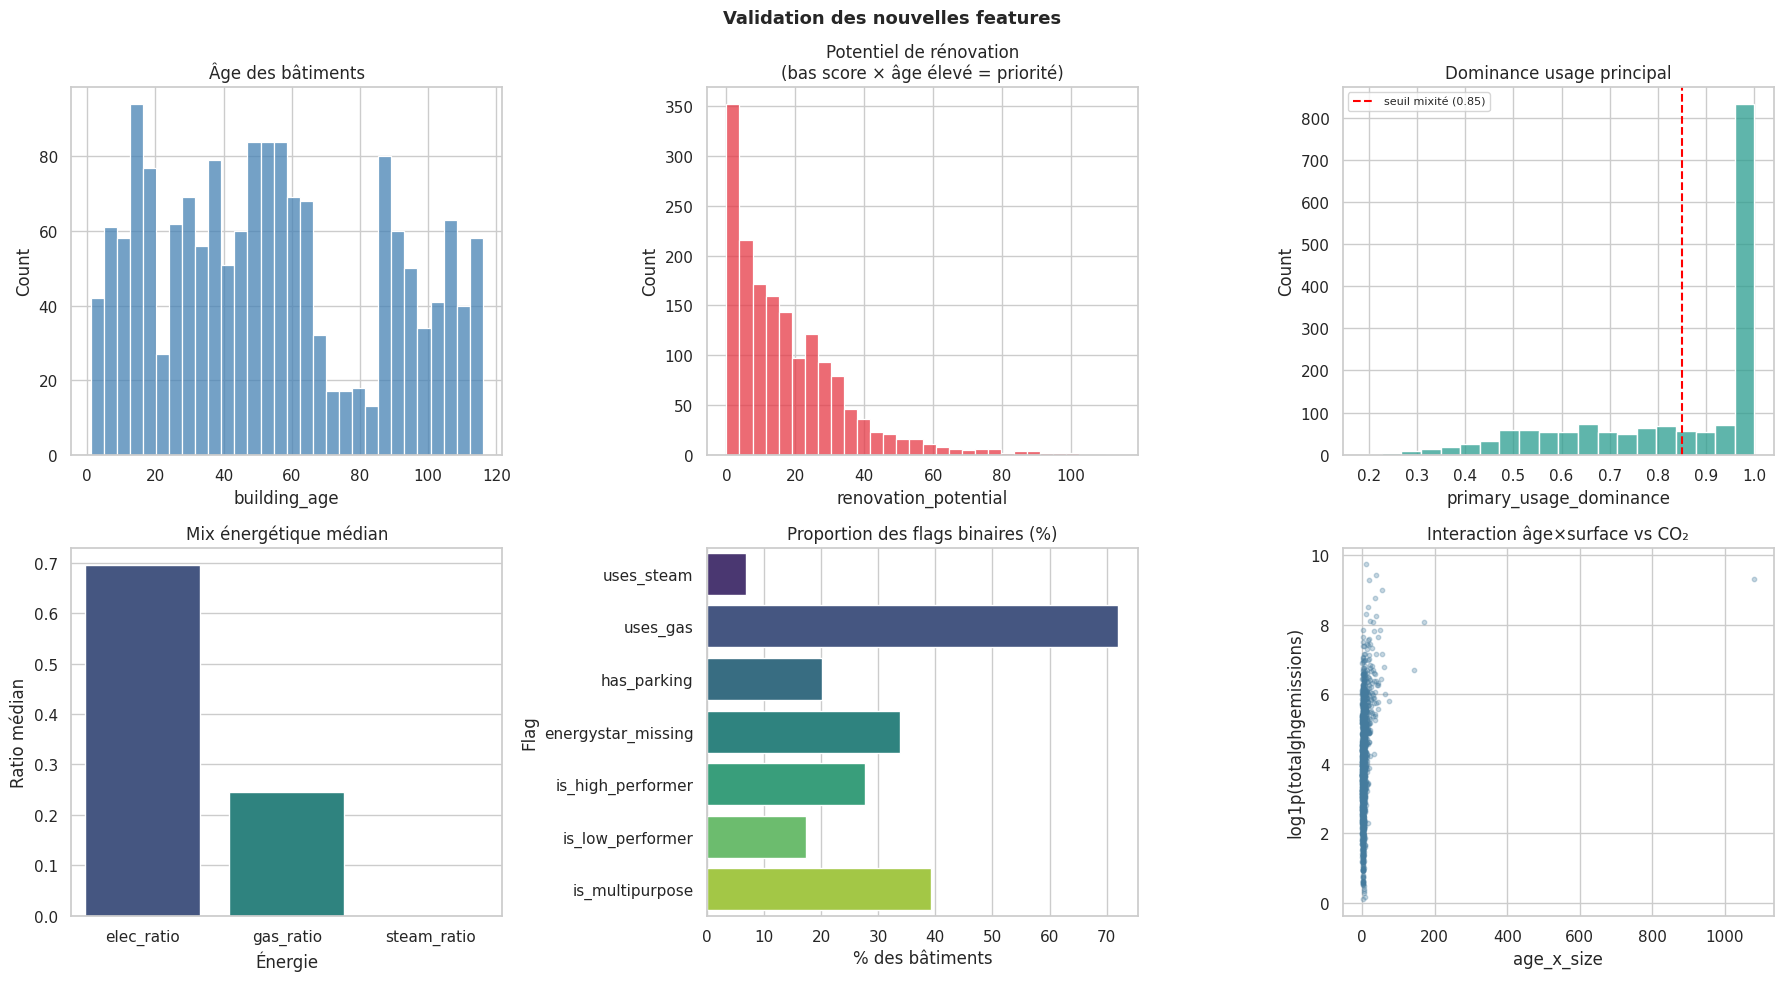

In [45]:
# ── Visualisation : validation des features clés ──────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Validation des nouvelles features', fontsize=13, fontweight='bold')

# building_age
sns.histplot(df['building_age'], bins=30, ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Âge des bâtiments')

# renovation_potential
sns.histplot(df['renovation_potential'], bins=30, ax=axes[0,1], color='#e63946')
axes[0,1].set_title('Potentiel de rénovation\n(bas score × âge élevé = priorité)')

# primary_usage_dominance
sns.histplot(df['primary_usage_dominance'], bins=20, ax=axes[0,2], color='#2a9d8f')
axes[0,2].axvline(0.85, color='red', linestyle='--', lw=1.5, label='seuil mixité (0.85)')
axes[0,2].set_title('Dominance usage principal')
axes[0,2].legend(fontsize=8)

# Mix énergétique
mix_data = df[['elec_ratio', 'gas_ratio', 'steam_ratio']].median().reset_index()
mix_data.columns = ['Énergie', 'Ratio médian']
sns.barplot(data=mix_data, x='Énergie', y='Ratio médian', ax=axes[1,0], palette='viridis')
axes[1,0].set_title('Mix énergétique médian')

# Flags binaires
flags = pd.DataFrame({
    'Flag'  : ['uses_steam', 'uses_gas', 'has_parking', 'energystar_missing',
               'is_high_performer', 'is_low_performer', 'is_multipurpose'],
    'Pct (%)': [
        df['uses_steam'].mean()*100,
        df['uses_gas'].mean()*100,
        df['has_parking'].mean()*100,
        df['energystar_missing'].mean()*100,
        df['is_high_performer'].mean()*100,
        df['is_low_performer'].mean()*100,
        df['is_multipurpose'].mean()*100,
    ]
})
sns.barplot(data=flags, x='Pct (%)', y='Flag', ax=axes[1,1], palette='viridis')
axes[1,1].set_title('Proportion des flags binaires (%)')
axes[1,1].set_xlabel('% des bâtiments')

# Relation age_x_size vs CO2
axes[1,2].scatter(df['age_x_size'], np.log1p(df[TARGET_CO2]),
                  alpha=0.3, s=10, color='#457b9d')
axes[1,2].set_xlabel('age_x_size')
axes[1,2].set_ylabel(f'log1p({TARGET_CO2})')
axes[1,2].set_title('Interaction âge×surface vs CO₂')

plt.tight_layout()
plt.show()

## ÉTAPE 5 — Corrélations & VIF

**Objectifs :**
1. Identifier les features les plus corrélées aux targets (`totalghgemissions`, `siteenergyusekbtu`)
2. Détecter la multicolinéarité entre features (VIF)
3. Décider quelles colonnes garder, fusionner ou supprimer avant la modélisation

**Pourquoi le VIF ?**
Le VIF (Variance Inflation Factor) mesure à quel point une feature est redondante
avec les autres. Un VIF > 10 signifie que la feature est quasiment reconstituable
par combinaison linéaire des autres → elle n'apporte pas d'information nouvelle
et peut déstabiliser les modèles linéaires (régression Ridge, Lasso).
Les modèles tree-based (XGBoost, RandomForest) sont plus tolérants à la multicolinéarité,
mais un VIF extrême (>50) reste problématique partout.

In [47]:
# Colonnes à exclure de l'analyse (targets, identifiants, catégorielles, textes)
EXCLUDE = [
    TARGET_CO2, TARGET_ENERGY,
    'buildingtype', 'primarypropertytype', 'propertyname',
    'address', 'city', 'state', 'zipcode', 'neighborhood',
    'largestpropertyusetype', 'compliancestatus', 'defaultdata',
    'construction_era',
]

# Features numériques pour l'analyse
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
FEATURES = [c for c in num_cols if c not in EXCLUDE]

print(f'Features numériques analysées : {len(FEATURES)}')

Features numériques analysées : 62


---
###  Corrélations avec les targets

On calcule la corrélation de Pearson entre chaque feature et **log1p(target)**
— c'est la forme que verra le modèle, donc c'est la corrélation pertinente.

In [48]:
# Corrélation avec log1p des targets
log_co2    = np.log1p(df[TARGET_CO2])
log_energy = np.log1p(df[TARGET_ENERGY])

corr_co2    = df[FEATURES].corrwith(log_co2).sort_values(key=abs, ascending=False)
corr_energy = df[FEATURES].corrwith(log_energy).sort_values(key=abs, ascending=False)

corr_df = pd.DataFrame({
    'Corr CO₂'   : corr_co2,
    'Corr Énergie': corr_energy,
}).sort_values('Corr CO₂', key=abs, ascending=False)

print('TOP 25 features par corrélation absolue avec log1p(CO₂) :')
display(corr_df.head(25).style
    .background_gradient(cmap='RdYlGn', subset=['Corr CO₂'], vmin=-1, vmax=1)
    .background_gradient(cmap='RdYlGn', subset=['Corr Énergie'], vmin=-1, vmax=1)
    .format('{:.3f}'))

TOP 25 features par corrélation absolue avec log1p(CO₂) :


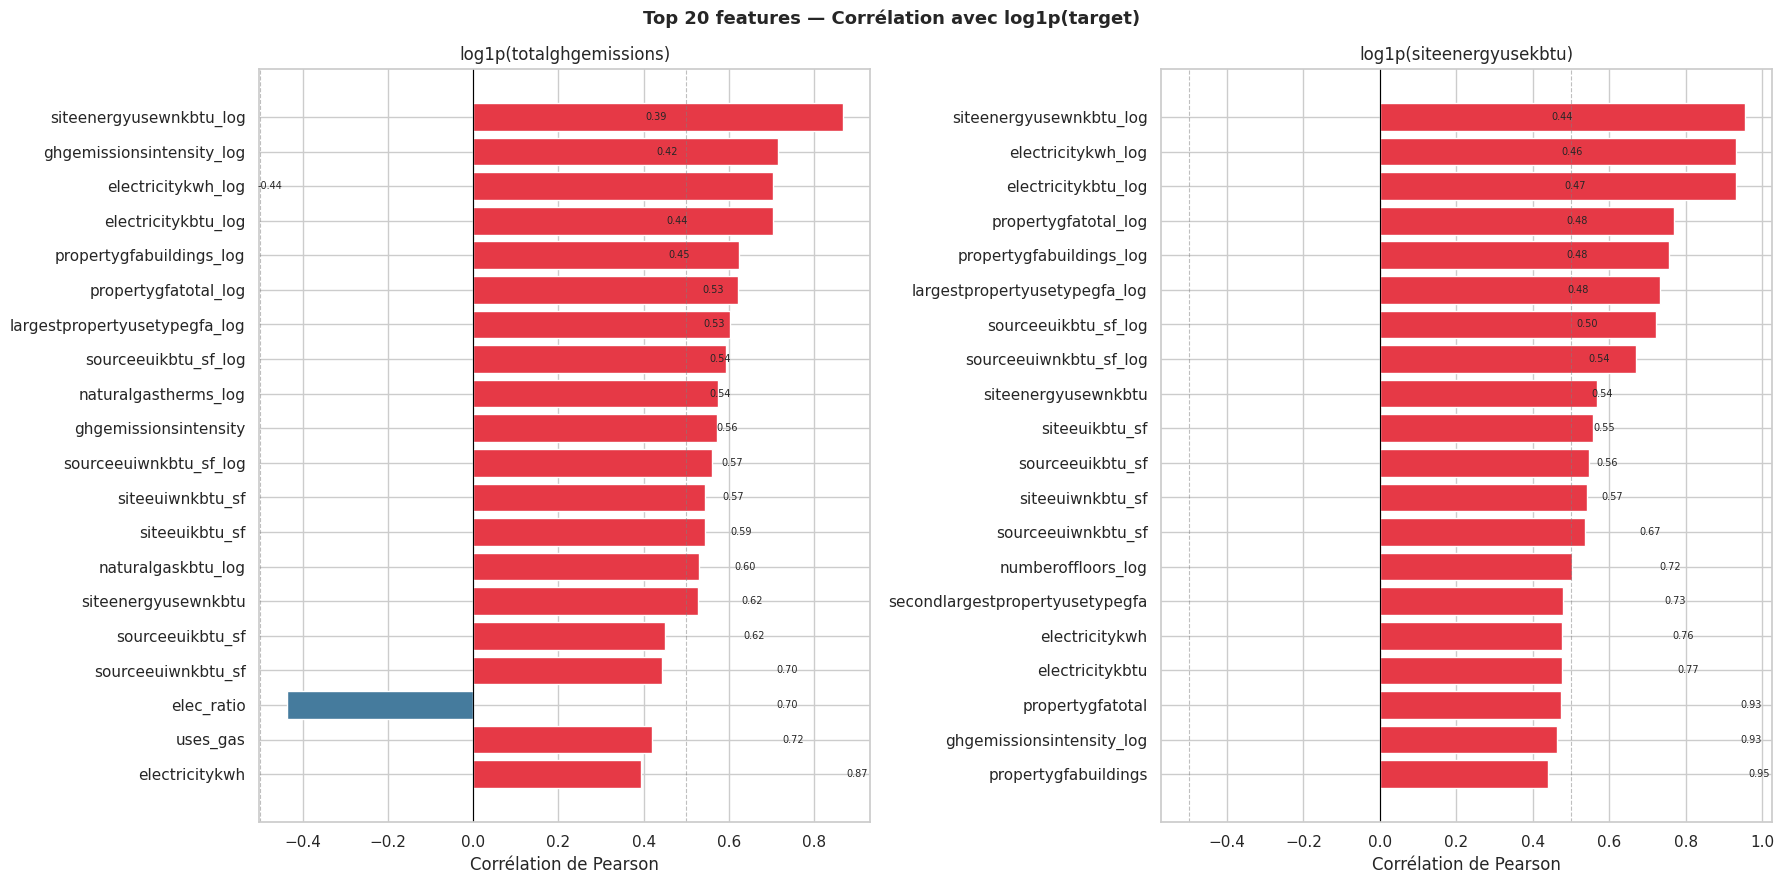

In [49]:
# Graphique : top 20 features par corrélation avec chaque target
fig, axes = plt.subplots(1, 2, figsize=(18, 9))
fig.suptitle('Top 20 features — Corrélation avec log1p(target)',
             fontsize=13, fontweight='bold')

for ax, corr, title, color_pos, color_neg in [
    (axes[0], corr_co2,    f'log1p({TARGET_CO2})',    '#e63946', '#457b9d'),
    (axes[1], corr_energy, f'log1p({TARGET_ENERGY})', '#e63946', '#457b9d'),
]:
    top = corr.sort_values(key=abs, ascending=False).head(20)
    colors = [color_pos if v > 0 else color_neg for v in top.values]
    bars = ax.barh(top.index[::-1], top.values[::-1], color=colors[::-1])
    ax.axvline(0, color='black', lw=0.8)
    ax.axvline( 0.5, color='gray', lw=0.8, linestyle='--', alpha=0.5)
    ax.axvline(-0.5, color='gray', lw=0.8, linestyle='--', alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('Corrélation de Pearson')
    for bar, val in zip(bars[::-1], top.values[::-1]):
        ax.text(val + 0.01 if val >= 0 else val - 0.01,
                bar.get_y() + bar.get_height()/2,
                f'{val:.2f}', va='center',
                ha='left' if val >= 0 else 'right', fontsize=7)

plt.tight_layout()
plt.show()

---
###  Heatmap des corrélations inter-features

On se concentre sur les features les plus corrélées aux targets (|corr| > 0.3)
pour garder la heatmap lisible.

Features avec |corr| > 0.3 : 36


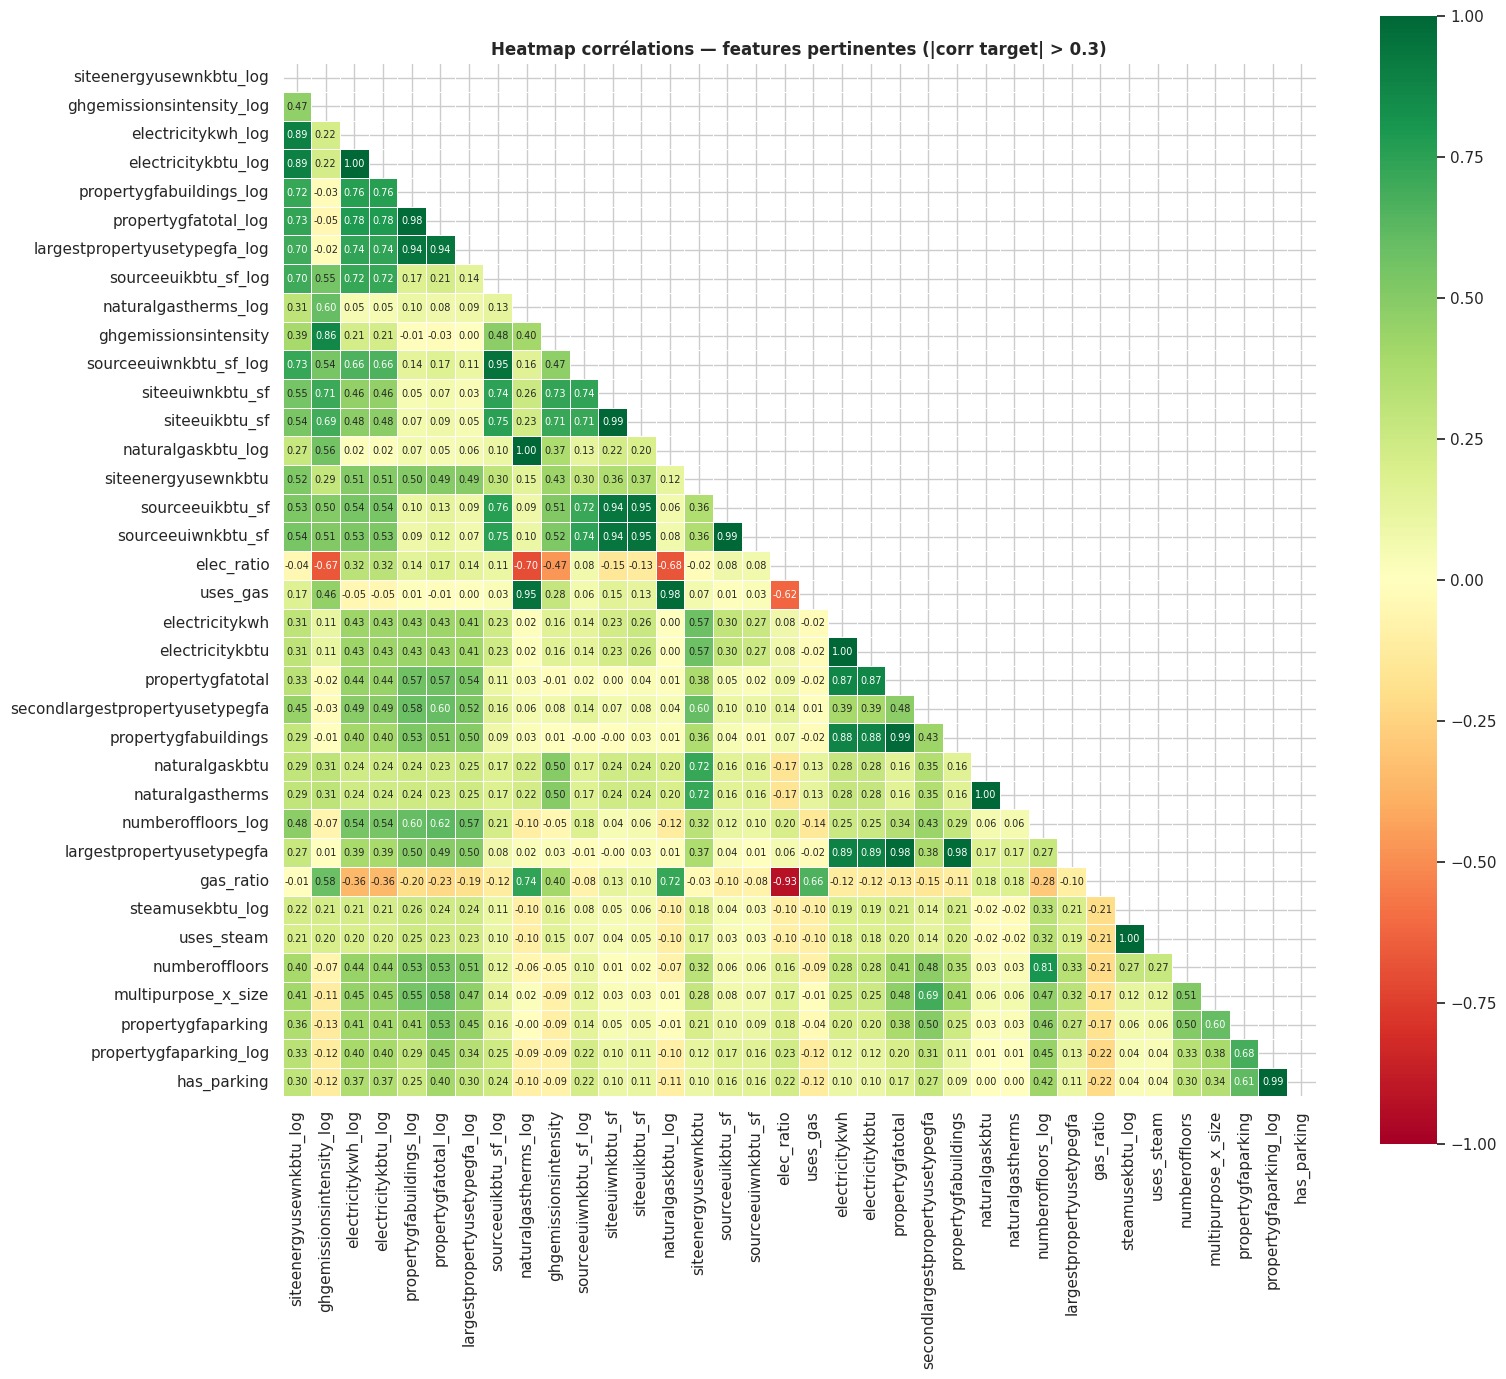

In [51]:
# Features avec |corr| > 0.3 avec au moins une target
threshold = 0.3
relevant = corr_df[
    (corr_df['Corr CO₂'].abs() > threshold) |
    (corr_df['Corr Énergie'].abs() > threshold)
].index.tolist()

print(f'Features avec |corr| > {threshold} : {len(relevant)}')

corr_matrix = df[relevant].corr()

# Masque triangle supérieur
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix, mask=mask,
    cmap='RdYlGn', vmin=-1, vmax=1,
    annot=True, fmt='.2f', annot_kws={'size': 7},
    linewidths=0.5, square=True
)
plt.title('Heatmap corrélations — features pertinentes (|corr target| > 0.3)',
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [52]:
# Paires hautement corrélées entre elles (|r| > 0.85)
print('Paires de features avec |corrélation| > 0.85 :')
print('─' * 60)

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        val = corr_matrix.iloc[i, j]
        if abs(val) > 0.85:
            high_corr_pairs.append({
                'Feature A'    : corr_matrix.columns[i],
                'Feature B'    : corr_matrix.columns[j],
                'Corrélation'  : round(val, 3),
                'Action suggérée': ''
            })

pairs_df = pd.DataFrame(high_corr_pairs).sort_values('Corrélation', key=abs, ascending=False)
display(pairs_df)

Paires de features avec |corrélation| > 0.85 :
────────────────────────────────────────────────────────────


Feature A                      Feature B  Corrélation  \
3          electricitykwh_log            electricitykbtu_log        1.000   
28             naturalgaskbtu               naturalgastherms        1.000   
18             electricitykwh                electricitykbtu        1.000   
29           steamusekbtu_log                     uses_steam        0.996   
8        naturalgastherms_log             naturalgaskbtu_log        0.995   
16           sourceeuikbtu_sf             sourceeuiwnkbtu_sf        0.994   
10           siteeuiwnkbtu_sf                 siteeuikbtu_sf        0.993   
30     propertygfaparking_log                    has_parking        0.993   
25           propertygfatotal           propertygfabuildings        0.990   
27       propertygfabuildings      largestpropertyusetypegfa        0.982   
4    propertygfabuildings_log           propertygfatotal_log        0.979   
26           propertygfatotal      largestpropertyusetypegfa        0.978   
15         naturalgaskbtu_log                       uses_gas        0.977   
9        naturalgastherms_log                       uses_gas        0.952   
7        sourceeuikbtu_sf_log         sourceeuiwnkbtu_sf_log        0.951   
13             siteeuikbtu_sf               sourceeuikbtu_sf        0.950   
14             siteeuikbtu_sf             sourceeuiwnkbtu_sf        0.946   
12           siteeuiwnkbtu_sf             sourceeuiwnkbtu_sf        0.945   
6        propertygfatotal_log  largestpropertyusetypegfa_log        0.943   
5    propertygfabuildings_log  largestpropertyusetypegfa_log        0.942   
11           siteeuiwnkbtu_sf               sourceeuikbtu_sf        0.936   
17                 elec_ratio                      gas_ratio       -0.927   
0     siteenergyusewnkbtu_log             electricitykwh_log        0.891   
1     siteenergyusewnkbtu_log            electricitykbtu_log        0.891   
24            electricitykbtu      largestpropertyusetypegfa        0.888   
21             electricitykwh      largestpropertyusetypegfa        0.888   
20             electricitykwh           propertygfabuildings        0.878   
23            electricitykbtu           propertygfabuildings        0.878   
22            electricitykbtu               propertygfatotal        0.868   
19             electricitykwh               propertygfatotal        0.868   
2   ghgemissionsintensity_log          ghgemissionsintensity        0.860   

   Action suggérée  
3                   
28                  
18                  
29                  
8                   
16                  
10                  
30                  
25                  
27                  
4                   
26                  
15                  
9                   
7                   
13                  
14                  
12                  
6                   
5                   
11                  
17                  
0                   
1                   
24                  
21                  
20                  
23                  
22                  
19                  
2

---
### Calcul du VIF

Le VIF se calcule uniquement sur les features qu'on envisage d'envoyer au modèle
— on exclut donc les doublons évidents déjà identifiés dans la heatmap.

**Interprétation :**
- VIF < 5 : pas de problème
- 5 ≤ VIF < 10 : multicolinéarité modérée — à surveiller
- VIF ≥ 10 : multicolinéarité forte — à traiter
- VIF ≥ 50 : redondance quasi-totale — à supprimer

In [53]:
# Colonnes à exclure du VIF : doublons évidents ou variables dérivées directes
# (ex: electricitykwh et electricitykbtu mesurent la même chose en unités différentes)
VIF_EXCLUDE = [
    'electricitykwh',          # doublon de electricitykbtu (facteur 3.412)
    'naturalgastherms',        # doublon de naturalgaskbtu (facteur 99.976)
    'siteenergyusewnkbtu',     # proxy direct de siteenergyusekbtu
    'siteeuiwnkbtu_sf',        # proxy de siteeuikbtu_sf
    'sourceeuiwnkbtu_sf',      # proxy de sourceeuikbtu_sf
    'ghgemissionsintensity',   # dérivé direct de totalghgemissions / surface
    'electricitykwh_log',      # doublon log de electricitykbtu_log
    'naturalgastherms_log',    # doublon log de naturalgaskbtu_log
    'siteenergyusewnkbtu_log', # proxy
    'siteeuiwnkbtu_sf',        # proxy
    'energystar_normalized',   # = energystarscore / 100, redondant
    'propertygfabuildings',    # très corrélé à propertygfatotal
    'propertygfabuildings_log',# idem version log
]

vif_features = [c for c in FEATURES
                if c not in VIF_EXCLUDE
                and df[c].nunique() > 1  # exclut les constantes
                and df[c].isnull().sum() == 0]

print(f'Features envoyées au VIF : {len(vif_features)}')

# Calcul VIF
X_vif = df[vif_features].copy().astype(float)

vif_results = []
for i, col in enumerate(X_vif.columns):
    vif_val = variance_inflation_factor(X_vif.values, i)
    vif_results.append({'Feature': col, 'VIF': round(vif_val, 2)})

vif_df = pd.DataFrame(vif_results).sort_values('VIF', ascending=False)

# Catégorisation
def vif_category(v):
    if v >= 50:  return '🔴 Supprimer'
    if v >= 10:  return '🟠 Problématique'
    if v >= 5:   return '🟡 Modéré'
    return '🟢 OK'

vif_df['Statut'] = vif_df['VIF'].apply(vif_category)

display(vif_df.style.background_gradient(
    cmap='RdYlGn_r', subset=['VIF'], vmin=1, vmax=50
).format({'VIF': '{:.2f}'}))

Features envoyées au VIF : 50


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


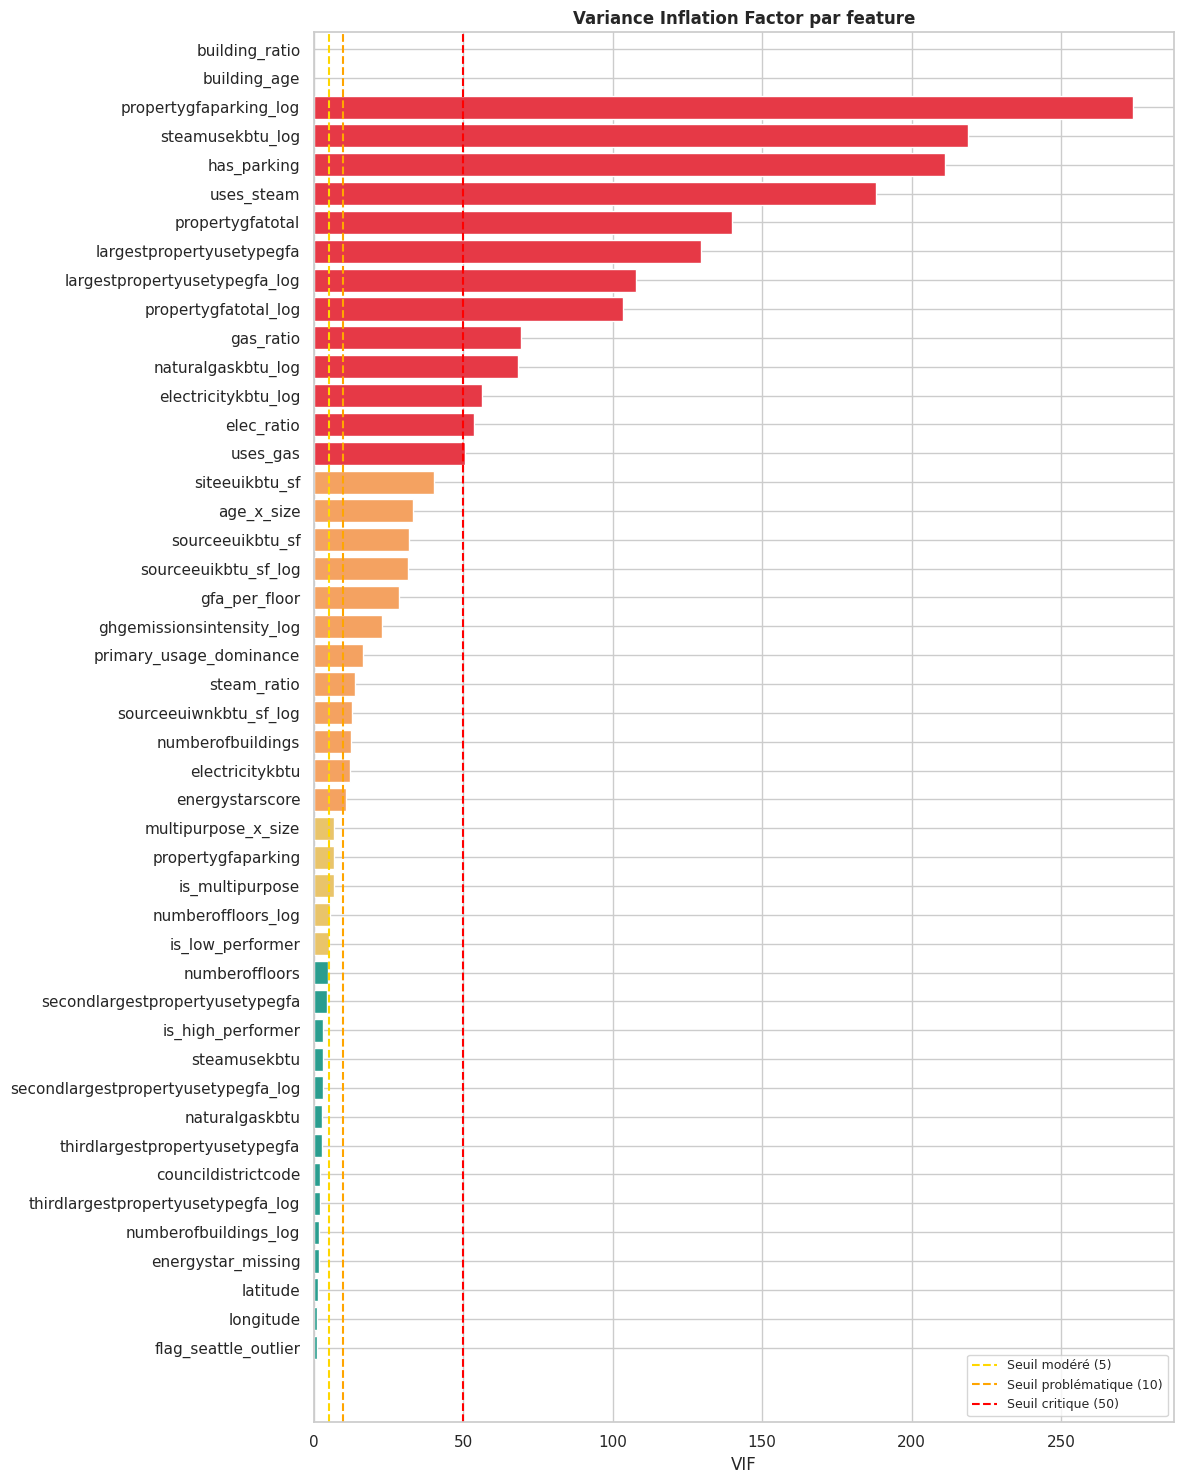


RÉSUMÉ VIF :
  🔴 VIF ≥ 50  : 19 features
  🟠 10 ≤ VIF < 50 : 12 features
  🟡  5 ≤ VIF < 10 : 5 features
  🟢 VIF < 5   : 14 features


In [54]:
# Graphique VIF
fig, ax = plt.subplots(figsize=(12, max(8, len(vif_df) * 0.3)))

colors = [
    '#e63946' if v >= 50 else
    '#f4a261' if v >= 10 else
    '#e9c46a' if v >= 5  else
    '#2a9d8f'
    for v in vif_df['VIF']
]

bars = ax.barh(vif_df['Feature'][::-1], vif_df['VIF'][::-1], color=colors[::-1])
ax.axvline(5,  color='gold',   linestyle='--', lw=1.5, label='Seuil modéré (5)')
ax.axvline(10, color='orange', linestyle='--', lw=1.5, label='Seuil problématique (10)')
ax.axvline(50, color='red',    linestyle='--', lw=1.5, label='Seuil critique (50)')
ax.set_xlabel('VIF')
ax.set_title('Variance Inflation Factor par feature', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

print(f'\nRÉSUMÉ VIF :')
print(f'  🔴 VIF ≥ 50  : {(vif_df["VIF"] >= 50).sum()} features')
print(f'  🟠 10 ≤ VIF < 50 : {((vif_df["VIF"] >= 10) & (vif_df["VIF"] < 50)).sum()} features')
print(f'  🟡  5 ≤ VIF < 10 : {((vif_df["VIF"] >= 5)  & (vif_df["VIF"] < 10)).sum()} features')
print(f'  🟢 VIF < 5   : {(vif_df["VIF"] < 5).sum()} features')

---
###  Décisions finales

On consolide ici toutes les décisions : features supprimées (redondance/VIF),
features conservées, et liste finale pour la modélisation.

In [55]:
# ── Colonnes à supprimer définitivement ──────────────────────────────────────
# Raisons :
# 1. Doublons en unités différentes → garder la version kBtu (SI)
# 2. Proxies quasi-directs de la target → data leakage potentiel
# 3. VIF > 50 → redondance totale
# 4. Variables brutes quand la version _log est disponible

COLS_TO_DROP_FINAL = [
    # Doublons unités
    'electricitykwh',          # doublon de electricitykbtu
    'electricitykwh_log',      # doublon de electricitykbtu_log
    'naturalgastherms',        # doublon de naturalgaskbtu
    'naturalgastherms_log',    # doublon de naturalgaskbtu_log
    # Proxies directs de la target énergie
    'siteenergyusewnkbtu',     # Weather-Normalized ≈ SiteEnergyUse
    'siteenergyusewnkbtu_log',
    'siteeuiwnkbtu_sf',        # proxy
    'sourceeuiwnkbtu_sf',      # proxy
    'sourceeuiwnkbtu_sf_log',  # proxy
    # Proxy direct de la target CO2
    'ghgemissionsintensity',   # = CO2 / surface — leakage quasi-total
    'ghgemissionsintensity_log',
    # Redondant avec propertygfatotal
    'propertygfabuildings',    # très corrélé (r > 0.99)
    'propertygfabuildings_log',
    # Redondant avec energystarscore
    'energystar_normalized',   # = score / 100, transformation linéaire
]

cols_dropped = [c for c in COLS_TO_DROP_FINAL if c in df.columns]
df_model = df.drop(columns=cols_dropped)

print(f'Colonnes supprimées : {len(cols_dropped)}')
for c in cols_dropped:
    print(f'  - {c}')
print(f'\nDataset pour modélisation : {df_model.shape[0]} lignes × {df_model.shape[1]} colonnes')

Colonnes supprimées : 14
  - electricitykwh
  - electricitykwh_log
  - naturalgastherms
  - naturalgastherms_log
  - siteenergyusewnkbtu
  - siteenergyusewnkbtu_log
  - siteeuiwnkbtu_sf
  - sourceeuiwnkbtu_sf
  - sourceeuiwnkbtu_sf_log
  - ghgemissionsintensity
  - ghgemissionsintensity_log
  - propertygfabuildings
  - propertygfabuildings_log
  - energystar_normalized

Dataset pour modélisation : 1648 lignes × 58 colonnes


In [57]:
# ── Suppressions complémentaires après analyse VIF ───────────────────────────
COLS_DROP_VIF = [
    # VIF infinis : variables dérivées dont les composantes sont déjà dans le dataset
    'yearbuilt',              # → remplacé par building_age
    'building_ratio',         # = propertygfabuildings / propertygfatotal (les deux présents)
    'parking_ratio',          # = propertygfaparking / propertygfatotal (les deux présents)
    'renovation_potential',   # = (100 - score) * building_age / 100 (composantes présentes)
    'score_x_age',            # = (100 - score) * building_age (composantes présentes)

    # Paires quasi-identiques (corr > 0.99) : garder la version la plus informative
    'steamusekbtu_log',       # corr=0.996 avec uses_steam → uses_steam suffit (binaire propre)
    'propertygfaparking_log', # corr=0.993 avec has_parking → has_parking suffit
    'uses_gas',               # corr=0.977 avec naturalgaskbtu_log → log plus informatif
    'gas_ratio',              # corr=-0.927 avec elec_ratio → redondant (1 - elec - steam)

    # Variables brutes quand la version _log est disponible
    'electricitykbtu',        # → electricitykbtu_log
    'naturalgaskbtu',         # → naturalgaskbtu_log
    'largestpropertyusetypegfa',   # → largestpropertyusetypegfa_log
    'propertygfatotal',            # → propertygfatotal_log
    'propertygfaparking',          # → has_parking (flag suffisant)
    'secondlargestpropertyusetypegfa',  # → secondlargestpropertyusetypegfa_log
    'thirdlargestpropertyusetypegfa',   # → thirdlargestpropertyusetypegfa_log
    'numberoffloors',          # → numberoffloors_log
    'numberofbuildings',       # → numberofbuildings_log
    'steamusekbtu',            # → uses_steam (flag suffisant)

    # EUI source : corrélation > 0.95 avec siteeuikbtu_sf, apport marginal
    'sourceeuikbtu_sf',        # corr=0.950 avec siteeuikbtu_sf
    'sourceeuikbtu_sf_log',    # idem version log
]

cols_dropped_vif = [c for c in COLS_DROP_VIF if c in df_model.columns]
df_model = df_model.drop(columns=cols_dropped_vif)

print(f'Suppressions complémentaires VIF : {len(cols_dropped_vif)} colonnes')
for c in cols_dropped_vif:
    print(f'  - {c}')
print(f'\nDataset final : {df_model.shape[0]} lignes × {df_model.shape[1]} colonnes')

# Vérification features restantes
final_num = [c for c in df_model.select_dtypes(include=[np.number]).columns
             if c not in [TARGET_CO2, TARGET_ENERGY]]
print(f'\nFeatures numériques restantes : {len(final_num)}')
print(final_num)

Suppressions complémentaires VIF : 21 colonnes
  - yearbuilt
  - building_ratio
  - parking_ratio
  - renovation_potential
  - score_x_age
  - steamusekbtu_log
  - propertygfaparking_log
  - uses_gas
  - gas_ratio
  - electricitykbtu
  - naturalgaskbtu
  - largestpropertyusetypegfa
  - propertygfatotal
  - propertygfaparking
  - secondlargestpropertyusetypegfa
  - thirdlargestpropertyusetypegfa
  - numberoffloors
  - numberofbuildings
  - steamusekbtu
  - sourceeuikbtu_sf
  - sourceeuikbtu_sf_log

Dataset final : 1648 lignes × 37 colonnes

Features numériques restantes : 27
['councildistrictcode', 'latitude', 'longitude', 'energystarscore', 'siteeuikbtu_sf', 'flag_seattle_outlier', 'numberofbuildings_log', 'largestpropertyusetypegfa_log', 'naturalgaskbtu_log', 'electricitykbtu_log', 'propertygfatotal_log', 'thirdlargestpropertyusetypegfa_log', 'numberoffloors_log', 'secondlargestpropertyusetypegfa_log', 'energystar_missing', 'uses_steam', 'has_parking', 'building_age', 'gfa_per_floor',

In [58]:
# ── Liste finale des features numériques pour la modélisation ─────────────────
final_num = [c for c in df_model.select_dtypes(include=[np.number]).columns
             if c not in [TARGET_CO2, TARGET_ENERGY]]
final_cat = ['primarypropertytype', 'neighborhood', 'construction_era', 'zipcode']

print('═' * 60)
print('  FEATURES FINALES POUR LA MODÉLISATION')
print('═' * 60)
print(f'  Numériques  : {len(final_num)}')
print(f'  Catégorielles (à encoder) : {len(final_cat)}')
print()

# Top features par corrélation avec chaque target
log_co2    = np.log1p(df_model[TARGET_CO2])
log_energy = np.log1p(df_model[TARGET_ENERGY])

corr_final = pd.DataFrame({
    'Corr CO₂'    : df_model[final_num].corrwith(log_co2),
    'Corr Énergie': df_model[final_num].corrwith(log_energy),
}).sort_values('Corr CO₂', key=abs, ascending=False)

print('TOP 15 features numériques finales :')
display(corr_final.head(15).style
    .background_gradient(cmap='RdYlGn', subset=['Corr CO₂'], vmin=-1, vmax=1)
    .background_gradient(cmap='RdYlGn', subset=['Corr Énergie'], vmin=-1, vmax=1)
    .format('{:.3f}'))

print()
print('Variables catégorielles à encoder (one-hot ou target encoding) :')
for c in final_cat:
    if c in df_model.columns:
        print(f'  {c:<30} {df_model[c].nunique()} modalités')

════════════════════════════════════════════════════════════
  FEATURES FINALES POUR LA MODÉLISATION
════════════════════════════════════════════════════════════
  Numériques  : 27
  Catégorielles (à encoder) : 4

TOP 15 features numériques finales :



Variables catégorielles à encoder (one-hot ou target encoding) :
  primarypropertytype            22 modalités
  neighborhood                   19 modalités
  construction_era               5 modalités
  zipcode                        49 modalités


In [59]:
# ── Sauvegarde du dataset de modélisation ─────────────────────────────────────
SAVE_MODEL_PATH = '/content/drive/MyDrive/D-CLIC/projet_energisight/data/df_modeling_ready.csv'
df_model.to_csv(SAVE_MODEL_PATH, index=False)

print(f'Dataset prêt pour la modélisation sauvegardé :')
print(f'   {SAVE_MODEL_PATH}')
print(f'   {df_model.shape[0]} lignes × {df_model.shape[1]} colonnes')
print()
print('RAPPEL MODÉLISATION :')
print(f'  y_co2    = np.log1p(df["{TARGET_CO2}"])')
print(f'  y_energy = np.log1p(df["{TARGET_ENERGY}"])')
print('  y_pred_reel = np.expm1(model.predict(X_test))')
print()
print('MÉTRIQUES CIBLES :')
print('  R² > 0.75  sur le jeu de test')
print('  RMSE en unités réelles (après expm1)')

Dataset prêt pour la modélisation sauvegardé :
   /content/drive/MyDrive/D-CLIC/projet_energisight/data/df_modeling_ready.csv
   1648 lignes × 37 colonnes

RAPPEL MODÉLISATION :
  y_co2    = np.log1p(df["totalghgemissions"])
  y_energy = np.log1p(df["siteenergyusekbtu"])
  y_pred_reel = np.expm1(model.predict(X_test))

MÉTRIQUES CIBLES :
  R² > 0.75  sur le jeu de test
  RMSE en unités réelles (après expm1)
